In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geodatasets as gds

import matplotlib.pyplot as plt 
import seaborn as sns
import contextily as cx
import mapclassify as mc
import folium as fm
import seaborn as sns
import matplotlib as mpl
import osmnx as ox


In [2]:
# Read file 'Data Files/passanten_tag_preprocessed.csv'

df_day = pd.read_csv('Data/Data Files/passanten_tag_preprocessed.csv')

In [3]:
df_day.head()

,date,weather_condition,temperature,min_temperature,pedestrians_count,location_id,location_name,GeoPunkt,day_of_week,month,longitude,latitude,is_weekend,is_holiday,season
0,2024-01-11,clear-day,0.0,-11.0,12585,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Thursday,January,9.934698,49.794834,0,0,Winter
1,2024-01-12,partly-cloudy-day,-2.0,-9.0,13515,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Friday,January,9.934698,49.794834,0,0,Winter
2,2024-01-13,cloudy,0.0,-3.0,13352,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Saturday,January,9.934698,49.794834,1,0,Winter
3,2024-01-14,partly-cloudy-day,0.0,-5.0,5335,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Sunday,January,9.934698,49.794834,1,0,Winter
4,2024-01-15,snow,1.0,-4.0,11718,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Monday,January,9.934698,49.794834,0,0,Winter


## 1. Location Analysis

- Save Map Location data in html file

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/3800763433.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set3', len(locations))  # z.B. 'Set1' für eine Farbkodierung


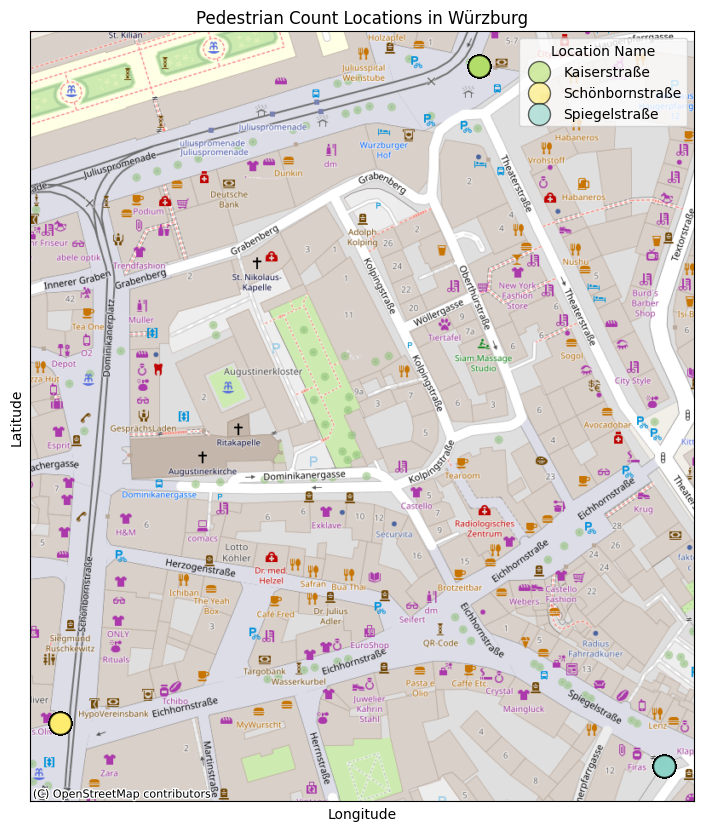

In [4]:
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import numpy as np
import matplotlib.colors as mcolors
#Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df_day, geometry=gpd.points_from_xy(df_day.longitude, df_day.latitude))

# Set the CRS (Coordinate Reference System) for the GeoDataFrame
gdf.crs = "EPSG:4326"  # WGS 84

# Convert to Web Mercator projection (EPSG:3857) for contextily
gdf = gdf.to_crs(epsg=3857)


# Annahme: Die GeoDataFrame hat eine Spalte 'location_name', die den Namen des Standorts enthält
# Verwende nur den Standortnamen in der Legende
gdf['location_name'] = gdf['location_name']  # falls es bereits eine Spalte gibt

# Farben definieren: Eine Farbkodierung basierend auf den Standortnamen
locations = gdf['location_name'].unique()
cmap = plt.cm.get_cmap('Set3', len(locations))  # z.B. 'Set1' für eine Farbkodierung
colors = {location: cmap(i) for i, location in enumerate(locations)}

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Zeichnen der Daten mit farbcodierten Standorten
for location, data in gdf.groupby('location_name'):
    color = colors[location]
    data.plot(ax=ax, color=color, markersize=250, 
              alpha=0.6, edgecolor='k', label=location)

# Hinzufügen der Basiskarte von contextily
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Labels und Titel setzen
ax.set_title('Pedestrian Count Locations in Würzburg')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Entfernen der x- und y-Achsenticks
ax.set_xticks([])
ax.set_yticks([])

# Legende hinzufügen, nur mit Standortnamen
ax.legend(title="Location Name", loc='upper right')

# Plot speichern
plt.savefig('Grafiken/Day/map_pedestrian_locations.png')

# Plot anzeigen
plt.show()


In [5]:
df_day.columns

Index(['date', 'weather_condition', 'temperature', 'min_temperature',
       'pedestrians_count', 'location_id', 'location_name', 'GeoPunkt',
       'day_of_week', 'month', 'longitude', 'latitude', 'is_weekend',
       'is_holiday', 'season'],
      dtype='object')

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/1864106025.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_pedestrians_per_location.values, y=avg_pedestrians_per_location.index, palette='viridis')


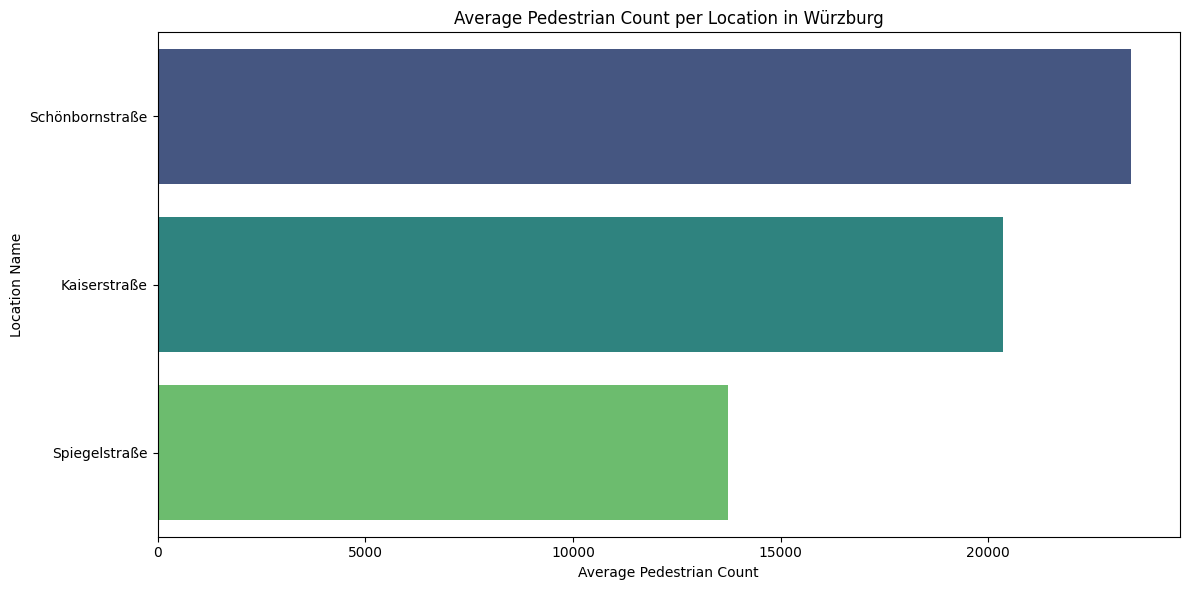

In [6]:
# Stellen sicher, dass die Spalte 'date' im DataFrame vorhanden und vom Typ datetime ist
df_day['date'] = pd.to_datetime(df_day['date'])

# Gruppieren nach 'location_name' und 'date', und die Summe der Fußgänger pro Tag berechnen
daily_pedestrians = df_day.groupby(['location_name', 'date'])['pedestrians_count'].sum().reset_index()

# Durchschnittliche Anzahl von Fußgängern pro Standort über alle Tage berechnen
avg_pedestrians_per_location = daily_pedestrians.groupby('location_name')['pedestrians_count'].mean()

# Die Standorte nach der durchschnittlichen Fußgängerzahl sortieren
avg_pedestrians_per_location = avg_pedestrians_per_location.sort_values(ascending=False)

# Zeige die Top 10 Standorte nach durchschnittlicher Fußgängeranzahl an
avg_pedestrians_per_location.head(10)

# Create a barplot of the average pedestrian counts per location
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_pedestrians_per_location.values, y=avg_pedestrians_per_location.index, palette='viridis')
plt.xlabel('Average Pedestrian Count')
plt.ylabel('Location Name')
plt.title('Average Pedestrian Count per Location in Würzburg')
plt.tight_layout()
plt.savefig('Grafiken/Day/barplot_avg_pedestrian_count_per_location.png')
plt.show()


In [7]:
# Calculate the total number of pedestrians per location

# Group by location and sum the pedestrians count
pedestrians_per_location = df_day.groupby('location_name')['pedestrians_count'].sum()

# Sort the locations by the total number of pedestrians
pedestrians_per_location = pedestrians_per_location.sort_values(ascending=False)

# Display the top 10 locations
pedestrians_per_location.head(10)





location_name
Schönbornstraße    39597686
Kaiserstraße       13988940
Spiegelstraße       9733496
Name: pedestrians_count, dtype: int64

- As we can see, most of the pedestrians are found in the Kaiserstraße
- Second Most Spiegelstraße
- Third Most Schönbornstraße

- This might be because the Kaiserstraße is close to the train station + city centre 
- the Spiegelstraße is close to the city center + Jura University
- the Schönbornstraße is close to the city center.



## 2. Univariate Analysis

### Impact of Public Bavarian Holidays

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/2006725932.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pedestrians_by_holiday.index, y=pedestrians_by_holiday.values, palette='viridis')


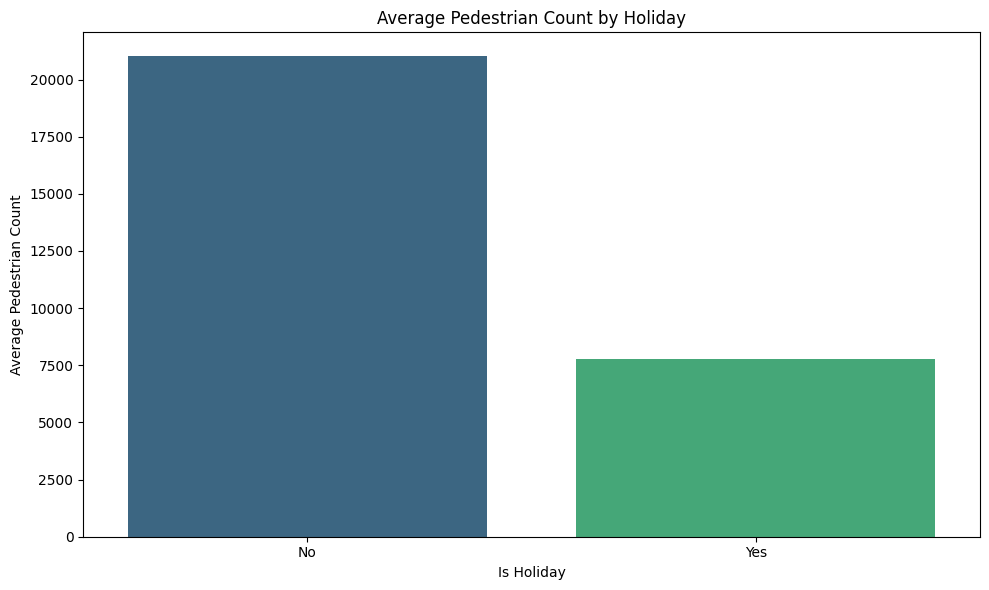

In [8]:
# show if there is a correlation between the number of pedestrians and if is_holiday is true

# Group by is_holiday and calculate the mean number of pedestrians
pedestrians_by_holiday = df_day.groupby('is_holiday')['pedestrians_count'].mean()

# Display the result
pedestrians_by_holiday

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=pedestrians_by_holiday.index, y=pedestrians_by_holiday.values, palette='viridis')
plt.xlabel('Is Holiday')
plt.ylabel('Average Pedestrian Count')
plt.title('Average Pedestrian Count by Holiday')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# save plot
# tight layout
plt.tight_layout()

plt.savefig('Grafiken/Day/average_pedestrian_count_by_holiday.png')

plt.show()


## Distribution of Pedestrians

In [9]:
average_pedestrian_count_general = df_day['pedestrians_count'].mean()

average_pedestrian_count_general

20525.16110210697

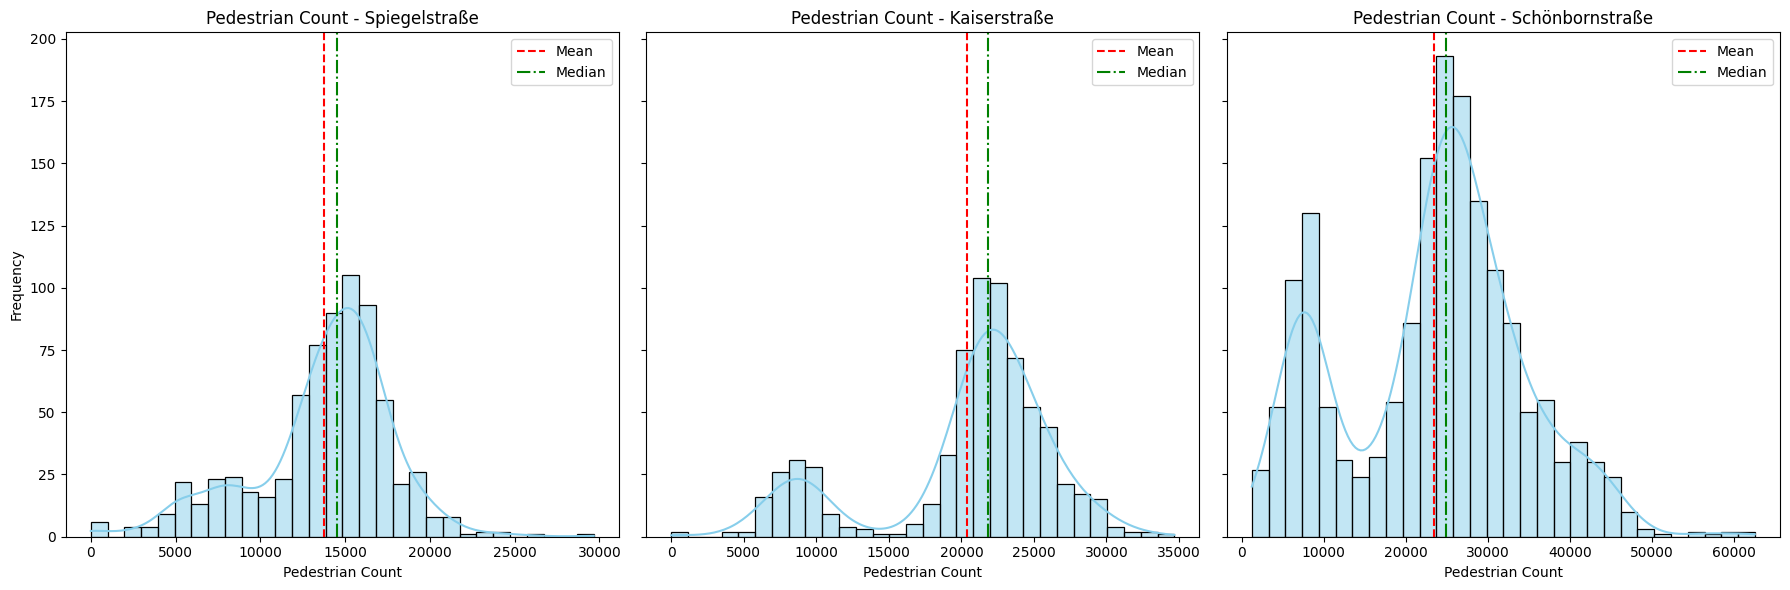

In [10]:

# Get unique locations
locations = df_day['location_name'].unique()

# Create a figure with subplots for each location
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, location in enumerate(locations):
    # Filter data for the current location
    location_data = df_day[df_day['location_name'] == location]
    
    # Compute mean and median
    average_pedestrian_count = location_data['pedestrians_count'].mean()
    median_pedestrian_count = location_data['pedestrians_count'].median()
    
    # Plot pedestrian count distribution for the current location
    sns.histplot(location_data['pedestrians_count'], bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].axvline(average_pedestrian_count, color='red', linestyle='--', label='Mean')
    axes[i].axvline(median_pedestrian_count, color='green', linestyle='-.', label='Median')
    axes[i].set_xlabel('Pedestrian Count')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Pedestrian Count - {location}')
    axes[i].legend()



# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig('Grafiken/Day/pedestrian_count_distribution_per_location.png')

# Show the plot
plt.show()


In [11]:
import pandas as pd

# Assuming df_day is the DataFrame containing the data

# Get unique locations
locations = df_day['location_name'].unique()

# Compute and print the mean and median for each location
for location in locations:
    # Filter data for the current location
    location_data = df_day[df_day['location_name'] == location]
    
    # Compute mean and median
    average_pedestrian_count = location_data['pedestrians_count'].mean()
    median_pedestrian_count = location_data['pedestrians_count'].median()
    
    # Print the statistics
    print(f"Location: {location}")
    print(f"Mean Pedestrian Count: {average_pedestrian_count}")
    print(f"Median Pedestrian Count: {median_pedestrian_count}")
    print("-" * 30)


Location: Spiegelstraße
Mean Pedestrian Count: 13728.485190409026
Median Pedestrian Count: 14534.0
------------------------------
Location: Kaiserstraße
Mean Pedestrian Count: 20362.35807860262
Median Pedestrian Count: 21866.0
------------------------------
Location: Schönbornstraße
Mean Pedestrian Count: 23444.4558910598
Median Pedestrian Count: 24952.0
------------------------------


In [12]:
# print distributions of pedestrian counts for each location

# Get unique locations
locations = df_day['location_name'].unique()

# Create a table to store the results

# Initialize an empty DataFrame
pedestrian_count_distributions = pd.DataFrame()

# Iterate over each location
for location in locations:
    # Filter data for the current location
    location_data = df_day[df_day['location_name'] == location]
    
    # Compute the pedestrian count distribution
    distribution = location_data['pedestrians_count'].describe()
    
    # Add the distribution to the table
    pedestrian_count_distributions[location] = distribution

# Display the table
pedestrian_count_distributions


,Spiegelstraße,Kaiserstraße,Schönbornstraße
count,709.000000,687.000000,1689.000000
mean,13728.485190,20362.358079,23444.455891
std,4111.658228,6196.530936,10991.741943
min,0.000000,0.000000,1258.000000
25%,12187.000000,19585.500000,15907.000000
50%,14534.000000,21866.000000,24952.000000
75%,16176.000000,24057.000000,30242.000000
max,29672.000000,34682.000000,62555.000000


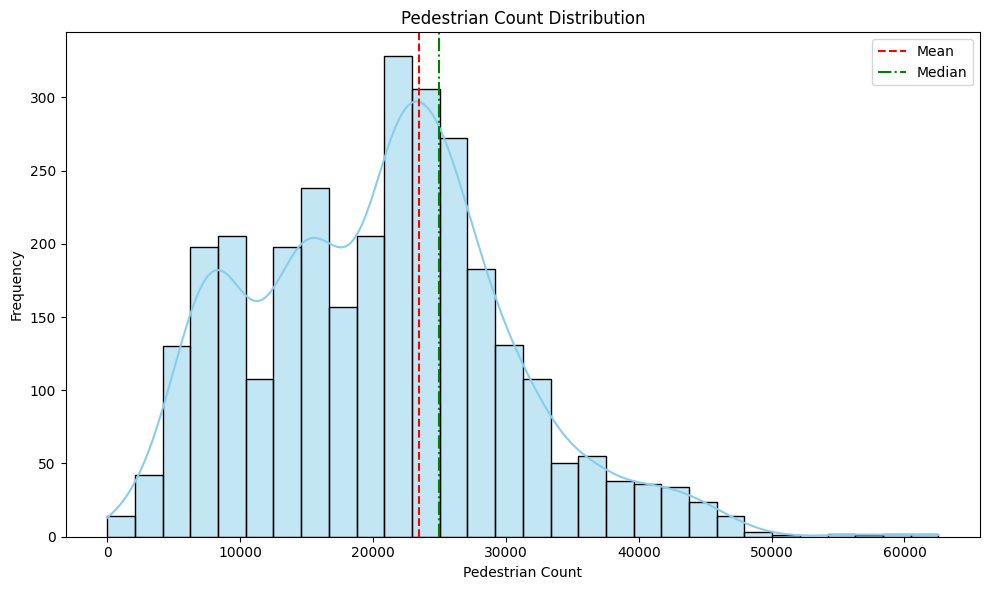

In [13]:
# pedestrian count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_day['pedestrians_count'], bins=30, kde=True, color='skyblue')
plt.axvline(average_pedestrian_count, color='red', linestyle='--', label='Mean')
plt.axvline(median_pedestrian_count, color='green', linestyle='-.', label='Median')
plt.xlabel('Pedestrian Count')
plt.ylabel('Frequency')
plt.title('Pedestrian Count Distribution')
plt.legend()
plt.tight_layout()
plt.savefig('Grafiken/Day/pedestrian_count_distribution.png')
plt.show()

## Analysis of numerial columns

In [15]:
numerical_columns = ['pedestrians_count', 'temperature']

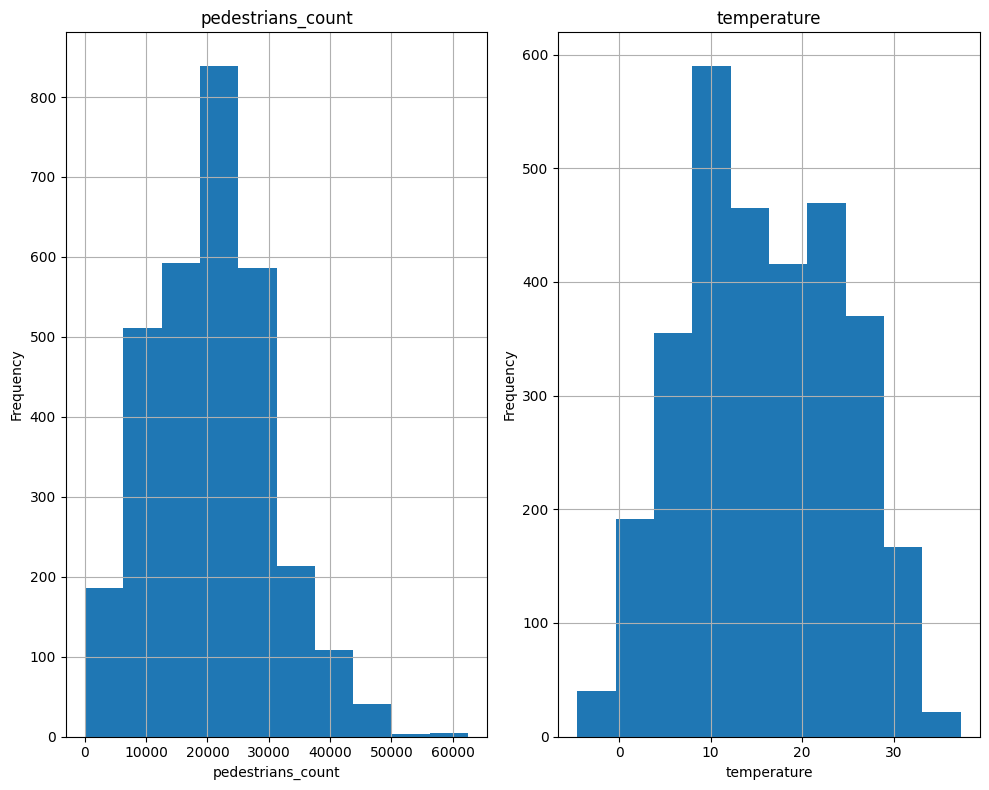

In [16]:
# Histograms for the numerical non-binary columns
axes = df_day[numerical_columns].hist(figsize=(10, 8))

for ax, column in zip(axes.flatten(), numerical_columns):
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")

plt.tight_layout()


# save plot
plt.savefig('Grafiken/Day/numerical_columns_histograms.png')

plt.show()



In [17]:

df_day[numerical_columns].describe().round(0).astype(int)
# Print the median of each numerical column


,pedestrians_count,temperature
count,3085,3085
mean,20525,16
std,9687,8
min,0,-5
25%,13344,10
50%,21178,16
75%,26351,23
max,62555,37


- Count: We have 3,085 observations of pedestrian counts, meaning the data covers a reasonably large dataset.

**Pedestrian Count Distribution**
- Mean (20,525 pedestrians): On average, there are around 20,525 pedestrians observed during the recorded periods.
- Standard Deviation (9,687): The large standard deviation suggests significant variability in the number of pedestrians across the dataset, indicating that some periods have far fewer pedestrians while others have many more.
- Minimum (0 pedestrians): There are instances where no pedestrians were recorded, which could be due to extreme weather conditions, time of day, or other factors.
- Maximum (62,555 pedestrians): The peak pedestrian count is quite high at 62,555, showing that certain periods experience heavy pedestrian traffic.
- 75th percentile: 26,351 pedestrians. These quartiles show the distribution of pedestrian counts, with the middle 50% of the data ranging from approximately 13,344 to 26,351 pedestrians

**Temperature**
- Mean (16°C): The average temperature recorded is 16°C
- Standard Deviation (8°C): There's a wide range of temperature variability, which is because the data is covering different seasons (winter and summer).
- Minimum (-5°C): The lowest recorded temperature is -5°C, which may occur in colder months.
- Maximum (37°C): The maximum temperature is quite high, 37°C, likely representing hot summer days.
- 75th percentile: 23°C (Warmer days). This shows that most temperatures fall between 10°C and 23°C, with the central tendency around 16°C.

**Minimum Temperature**
- Mean (6°C): On average, the minimum daily temperature is 6°C, indicating that nights or early mornings tend to be cool.
- Standard Deviation (6°C): The variability is moderate here, suggesting that some days have significantly cooler minimum temperatures.
- Minimum (-15°C): The lowest recorded temperature is -15°C, suggesting this dataset includes data from very cold periods, likely winter or early morning lows.
- Maximum (20°C): The maximum minimum temperature is 20°C, indicating that even during the coolest parts of certain days, the temperature can remain relatively warm.
- 75th percentile: 11°C (Mild nights/mornings). The minimum temperature data suggests a mix of cold and mild periods, possibly reflecting seasonal changes.

**Insights and Hypotheses:**
- Pedestrian Count & Temperature Relationship: Given the variability in both pedestrian counts and temperatures, it is likely that temperature could influence pedestrian behavior. Warmer days may encourage more people to be outside, leading to higher pedestrian counts, while colder days (e.g., minimum temperatures below 0°C) could see lower foot traffic.
- Seasonal Trends: The temperature range suggests that the data spans multiple seasons, potentially allowing for analysis of how pedestrian counts change across seasons.
- Weather Extremes: Extreme values (very low or very high temperatures) might correspond to outliers in pedestrian counts, potentially leading to lower counts during extreme cold or heat.

These insights suggest that further analysis could focus on investigating the relationship between pedestrian counts and temperature to uncover trends or seasonality effects.

In [18]:
# Calculate the median of the pedestrians_count column, grouped by location_name

median_pedestrians_per_location = df_day.groupby('location_name')['pedestrians_count'].median()
median_pedestrians_per_location

location_name
Kaiserstraße       21866.0
Schönbornstraße    24952.0
Spiegelstraße      14534.0
Name: pedestrians_count, dtype: float64

## Correlation Matrix

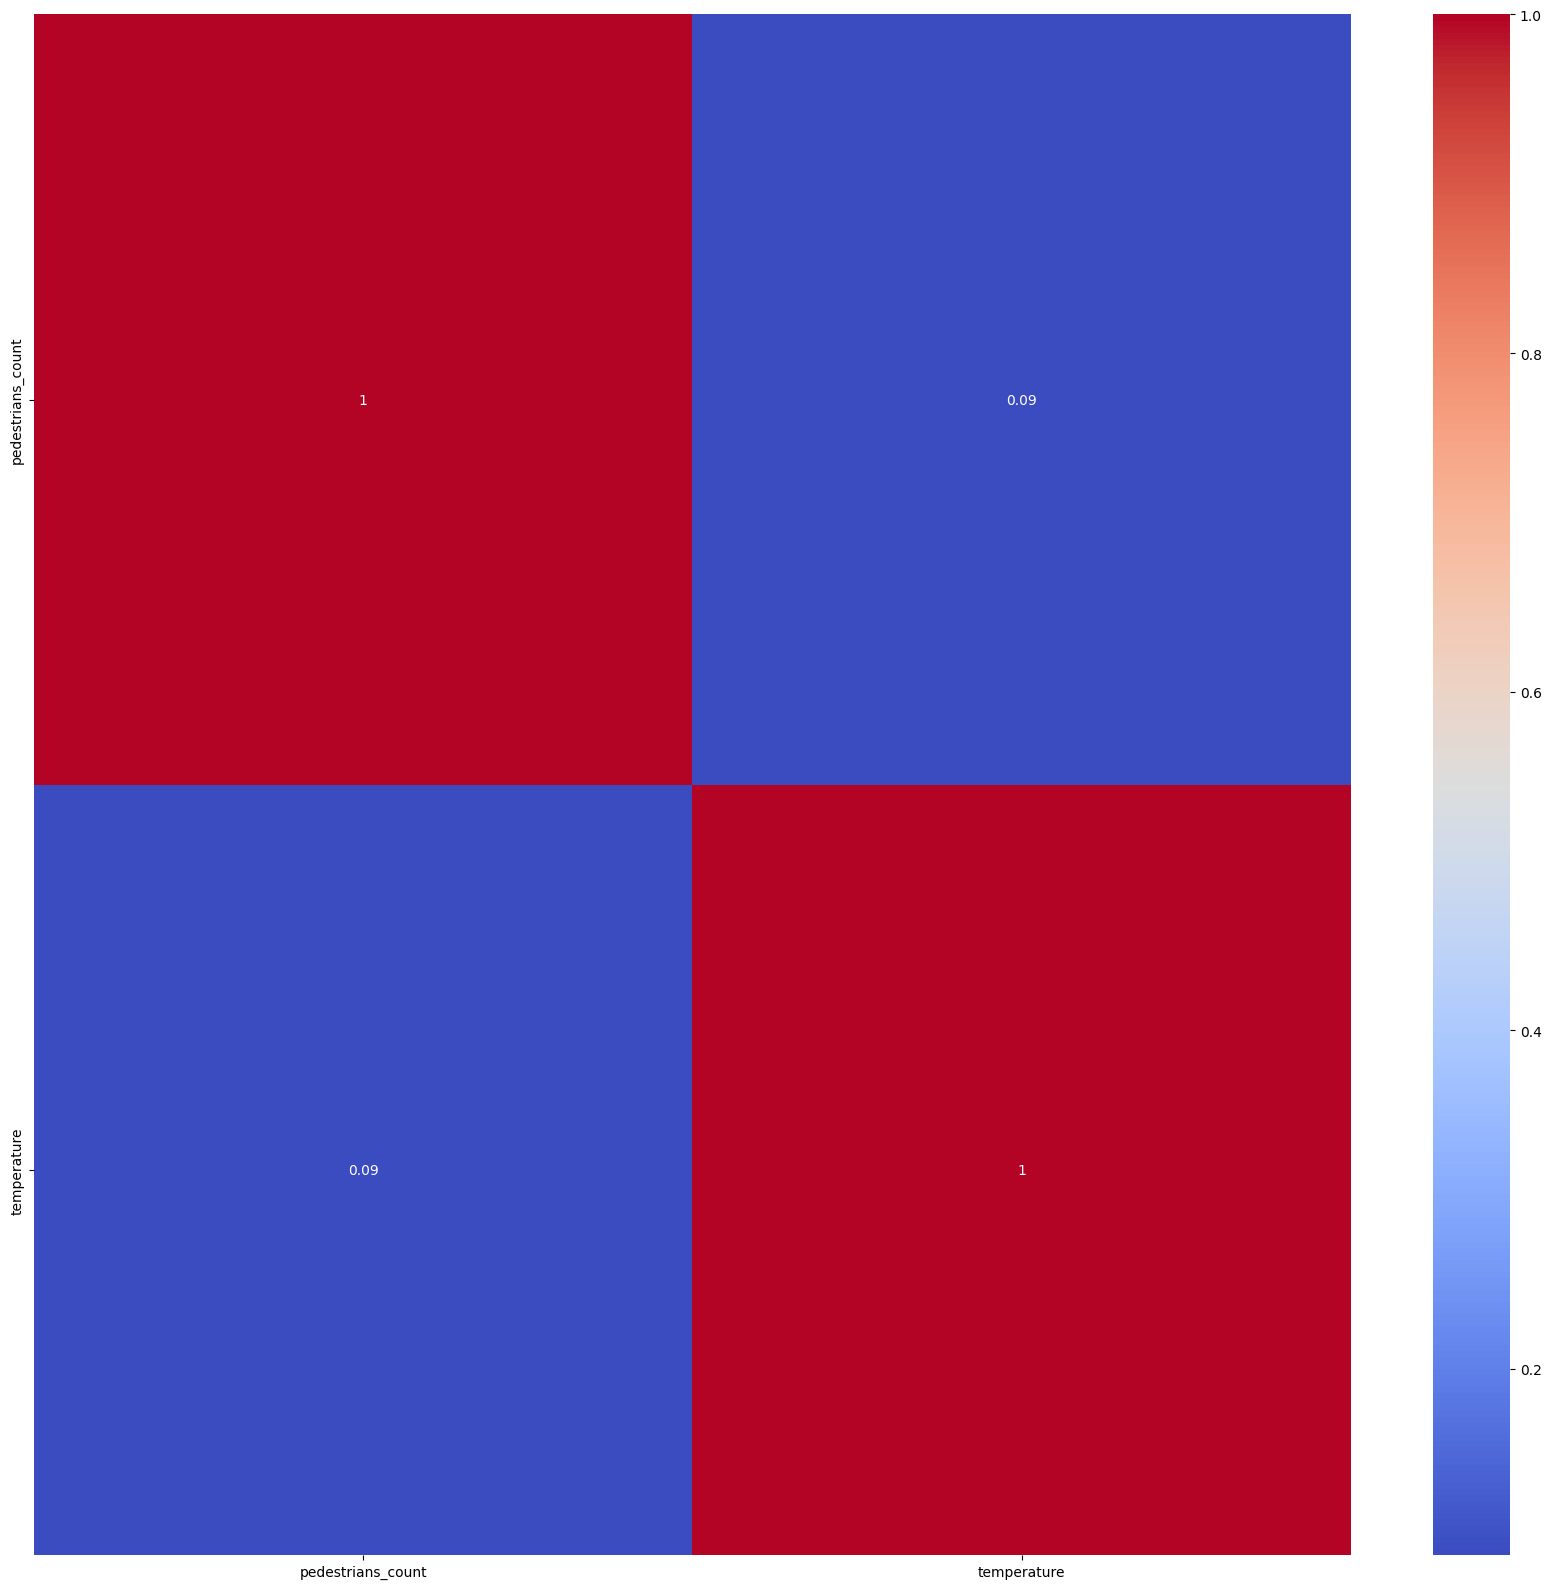

In [19]:
# Now plot the heatmap of the correlation matrix

correlation_matrix = df_day[numerical_columns].corr().round(2) 


# Make the figure large
plt.figure(figsize=(17, 16))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Adjust layout to prevent label cut-off
plt.tight_layout()

# save plot
plt.savefig('Grafiken/Day/correlation_matrix.png')

plt.show()

Based on the correlation values:



- **Pedestrian Count & Temperature (Correlation = 0.09):** A weak positive correlation of 0.09 suggests that temperature has little to no impact on the number of pedestrians. This is somewhat surprising, as you might expect more pedestrians on warmer days. However, this low correlation indicates that other factors beyond temperature (e.g., time of day, day of the week, events, or location) are likely playing a much larger role in influencing pedestrian activity.



- Temperature has little influence on pedestrian activity: The very low correlations between both temperature and minimum temperature with pedestrian count (0.09 and 0.08 respectively) indicate that pedestrian behavior is not strongly impacted by temperature changes. This suggests that other factors—such as work schedules, public events, or social habits—are more important in determining how many people are walking outside. Despite wide variability in temperatures, pedestrian traffic remains relatively consistent.

- Potential Factors Beyond Weather: Given these weak correlations, it would be valuable to investigate other potential factors influencing pedestrian counts (e.g., time of day, day of the week, holidays, or local events) to see if there are stronger predictors of pedestrian activity than weather alone.

### Pedestrians per temperature

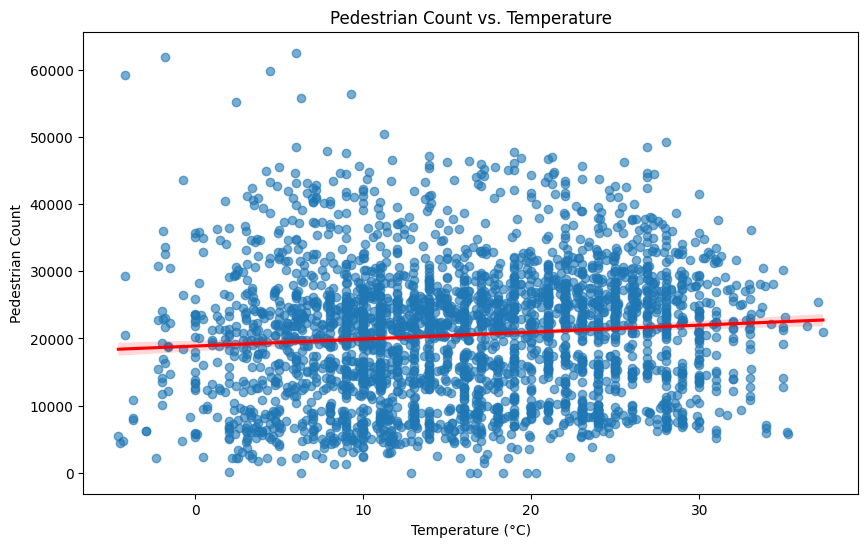

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Beispiel-Daten (dies solltest du durch deinen tatsächlichen DataFrame ersetzen)
# df_day = pd.DataFrame({
#     'temperature': [15, 20, 25, 30, 35],
#     'pedestrians_count': [100, 150, 200, 250, 300]
# })

# Plot erstellen
plt.figure(figsize=(10, 6))
sns.regplot(x='temperature', y='pedestrians_count', data=df_day, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.xlabel('Temperature (°C)')
plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count vs. Temperature')

# Plot speichern
plt.savefig('Grafiken/Day/pedestrian_counts_vs_temperature.png')
plt.show()


- Although the correlation is weak, there is a correlation between temperature and pedestrian count. The scatter plot shows that pedestrian counts tend to be higher on warmer days, with a few exceptions. This suggests that temperature may play a role in influencing pedestrian activity, even if the correlation is not very strong.
- But the plot also shows that there are not many pedestrians on very hot days (warmer than 30°C), which could be due to people avoiding extreme heat or staying indoors during such conditions. There are also less pedestrians on very cold days (colder than 0°C), which is expected due to the discomfort of walking in cold weather.

## Lag Plot

In [21]:
df_day

,date,weather_condition,temperature,min_temperature,pedestrians_count,location_id,location_name,GeoPunkt,day_of_week,month,longitude,latitude,is_weekend,is_holiday,season
0,2024-01-11,clear-day,0.0,-11.0,12585,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Thursday,January,9.934698,49.794834,0,0,Winter
1,2024-01-12,partly-cloudy-day,-2.0,-9.0,13515,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Friday,January,9.934698,49.794834,0,0,Winter
2,2024-01-13,cloudy,0.0,-3.0,13352,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Saturday,January,9.934698,49.794834,1,0,Winter
3,2024-01-14,partly-cloudy-day,0.0,-5.0,5335,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Sunday,January,9.934698,49.794834,1,0,Winter
4,2024-01-15,snow,1.0,-4.0,11718,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Monday,January,9.934698,49.794834,0,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080,2024-08-15,partly-cloudy-day,28.0,19.0,6706,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Thursday,August,9.934698,49.794834,0,1,Summer
3081,2024-08-15,partly-cloudy-day,28.0,19.0,8413,476,Kaiserstraße,"49.798498976405355, 9.933887635731686",Thursday,August,9.933534,49.797680,0,1,Summer
3082,2024-08-17,rain,28.0,18.0,33834,135,Schönbornstraße,"49.795490162266525, 9.931060093195851",Saturday,August,9.930892,49.795012,1,0,Summer
3083,2024-08-17,rain,28.0,18.0,14251,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Saturday,August,9.934698,49.794834,1,0,Summer


In [22]:
def get_lags(df):

    
    # Sort dataframe by 'location' and 'timestamp'
    df.sort_values(by=['location_name', 'date'], inplace=True)

    # Get 7-day lag for the 'pedestrians_count' column

    df['pedestrians_count_7d_lag'] = np.nan

    lag = 7

    # Split the dataframe into groups based on the 'location' column and get the 7-day lag for each group
    locations  = df['location_name'].unique()

    for location in locations:
        mask = df['location_name'] == location
        df.loc[mask, 'pedestrians_count_7d_lag'] = df.loc[mask, 'pedestrians_count'].shift(lag)

    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Sort dataframe by 'timestamp' and 'location'
    df.sort_values(by=['date', 'location_name'], inplace=True)

    # Reset the index
    df.reset_index(drop=True, inplace=True)

    return df

In [23]:
get_lags(df_day)

df_day.head()

,date,weather_condition,temperature,min_temperature,pedestrians_count,location_id,location_name,GeoPunkt,day_of_week,month,longitude,latitude,is_weekend,is_holiday,season,pedestrians_count_7d_lag
0,2020-01-08,rain,6.62,0.45,23928,135,Schönbornstraße,"49.795490162266525, 9.931060093195851",Wednesday,January,9.930892,49.795012,0,0,Winter,7285.0
1,2020-01-09,rain,12.11,6.14,29521,135,Schönbornstraße,"49.795490162266525, 9.931060093195851",Thursday,January,9.930892,49.795012,0,0,Winter,40406.0
2,2020-01-10,rain,10.05,5.65,30220,135,Schönbornstraße,"49.795490162266525, 9.931060093195851",Friday,January,9.930892,49.795012,0,0,Winter,41095.0
3,2020-01-11,partly-cloudy-day,5.92,-0.43,44711,135,Schönbornstraße,"49.795490162266525, 9.931060093195851",Saturday,January,9.930892,49.795012,1,0,Winter,42096.0
4,2020-01-12,partly-cloudy-day,4.48,-1.95,7309,135,Schönbornstraße,"49.795490162266525, 9.931060093195851",Sunday,January,9.930892,49.795012,1,0,Winter,7847.0


In [24]:
print(df_day.columns)


Index(['date', 'weather_condition', 'temperature', 'min_temperature',
       'pedestrians_count', 'location_id', 'location_name', 'GeoPunkt',
       'day_of_week', 'month', 'longitude', 'latitude', 'is_weekend',
       'is_holiday', 'season', 'pedestrians_count_7d_lag'],
      dtype='object')


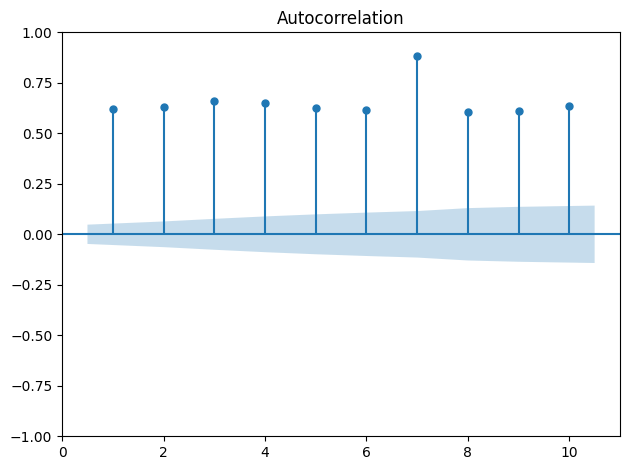

In [25]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

df_day_sum = df_day.groupby('date')['pedestrians_count'].sum()

plot_acf(df_day_sum, lags=(1, 2, 3, 4, 5, 6, 7, 8, 9 ,10))
# tight layout
plt.tight_layout()
# save plot
plt.savefig('Grafiken/Day/autocorrelation_plot.png')

plt.show()

### Month dependent on Pedestrian Count

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/1633149513.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pedestrians_per_month.index, y=pedestrians_per_month.values, palette='viridis')


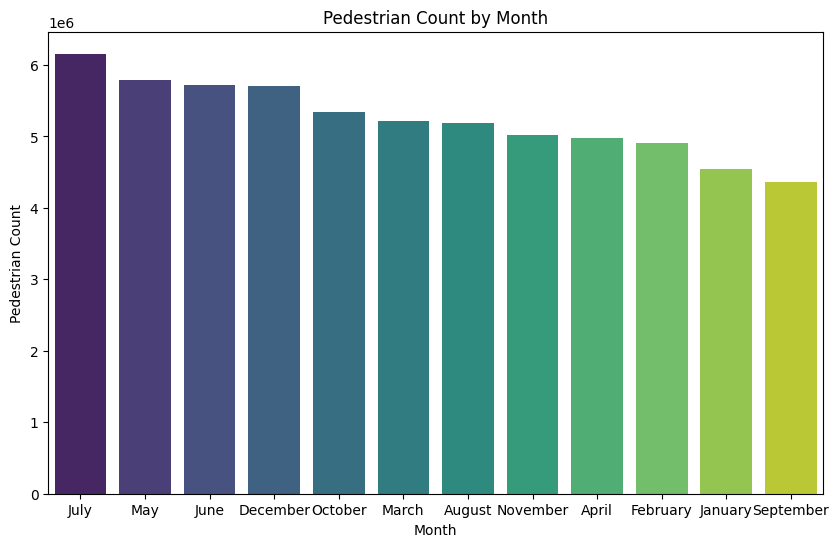

In [26]:
# show how many pedestrians are counted in each month

# Count the number of pedestrians for each month
pedestrians_per_month = df_day.groupby('month')['pedestrians_count'].sum()

# Sort the months by their number of pedestrians
pedestrians_per_month = pedestrians_per_month.sort_values(ascending=False)

# Display the total number of pedestrians per month
pedestrians_per_month


# Create a plot that shows the number of pedestrians counted
# in each month

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=pedestrians_per_month.index, y=pedestrians_per_month.values, palette='viridis')

plt.xlabel('Month')

plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count by Month')

# save plot
plt.savefig('Grafiken/Day/pedestrian_count_by_month.png')

plt.show()

- As we can see, most of the pedestrians in Würzburg are found in July, May June and December. (There are also the most events in Wü)
- The least pedestrians are found in February, January and September (There are also the least events in Wü)

### Distribution of season dependent on Pedestrian Count

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/1106575504.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pedestrians_per_season.index, y=pedestrians_per_season.values, palette='viridis')


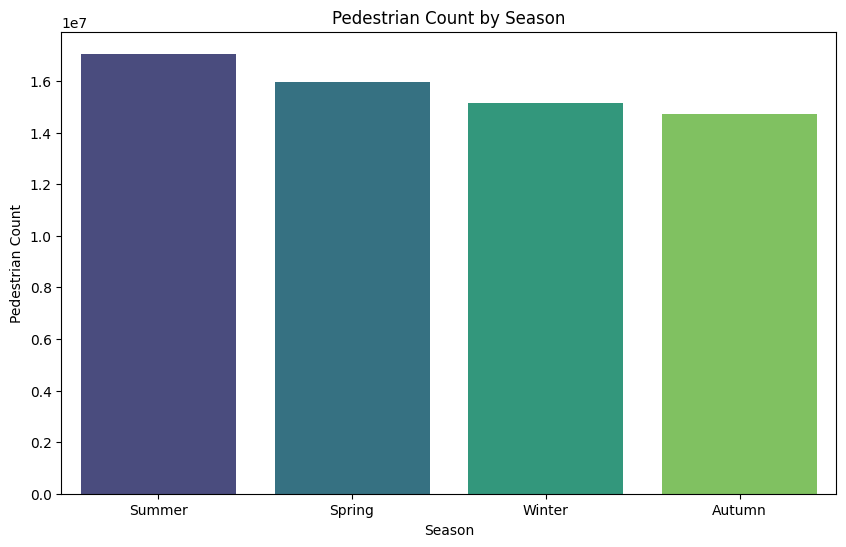

In [27]:
# Count the number of pedestrians for each season
pedestrians_per_season = df_day.groupby('season')['pedestrians_count'].sum()

# Sort the seasons by their number of pedestrians
pedestrians_per_season = pedestrians_per_season.sort_values(ascending=False)

# Display the total number of pedestrians per season
pedestrians_per_season

# Create a plot that shows the number of pedestrians counted
# in each season

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=pedestrians_per_season.index, y=pedestrians_per_season.values, palette='viridis')

plt.xlabel('Season')
plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count by Season')

# save plot
plt.savefig('Grafiken/Day/pedestrian_count_by_season.png')

plt.show()


- Like we already saw in the month dependent on pedestrian count, most of the pedestrians are found in summer annd spring.
- The least pedestrians are found in autumn.
- There is no big differences in pedestrian counts between the different seasons.

### Temperature & Season

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/589545059.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_temperature_per_season.index, y=average_temperature_per_season.values, palette='viridis')


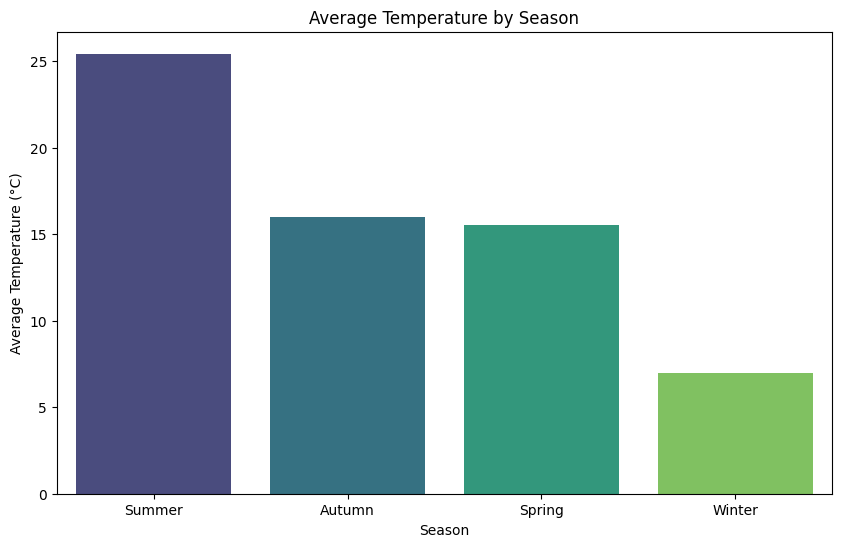

In [28]:
# Show the season with the highest temperatures

# Calculate the average temperature for each season
average_temperature_per_season = df_day.groupby('season')['temperature'].mean()

# Sort the seasons by their average temperature
average_temperature_per_season = average_temperature_per_season.sort_values(ascending=False)

# Display the average temperature per season
average_temperature_per_season

# Create a plot that shows the average temperature in each season

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=average_temperature_per_season.index, y=average_temperature_per_season.values, palette='viridis')

plt.xlabel('Season')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature by Season')

# save plot
plt.savefig('Grafiken/Day/average_temperature_by_season.png')

plt.show()

- In Würzburg, the temperature is mostly between 0 and 25 degrees.


### Distribution of weekday and Pedestrian Count

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/2300491456.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pedestrians_per_day_of_week.index, y=pedestrians_per_day_of_week.values, palette='viridis')


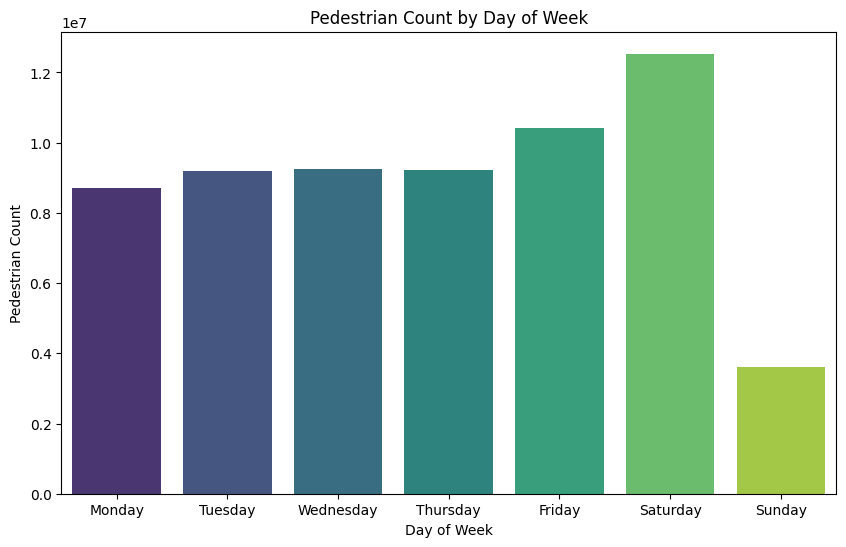

In [29]:
weekday_order = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}



# Count the number of pedestrians for each day of the week
pedestrians_per_day_of_week = df_day.groupby('day_of_week')['pedestrians_count'].sum()


# Display the total number of pedestrians per day of the week
# Monday=0, Sunday=6
pedestrians_per_day_of_week = pedestrians_per_day_of_week.sort_index(key=lambda x: x.map(weekday_order))

# Create a plot that shows the number of pedestrians counted
# on each day of the week

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=pedestrians_per_day_of_week.index, y=pedestrians_per_day_of_week.values, palette='viridis')

plt.xlabel('Day of Week')
plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count by Day of Week')

# save plot
plt.savefig('Grafiken/Day/pedestrian_count_by_day_of_week.png')

plt.show()

- The least pedestrians are found on Sunday (probably because the shops are closed on Sunday)
- The most pedestrians are found on Saturday (probably because people are shopping on Saturday)
- The second most pedestrians are found on Fridays

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/3780848308.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='pedestrians_count', data=data, ax=axes[i], palette='viridis')
/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/3780848308.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='pedestrians_count', data=data, ax=axes[i], palette='viridis')
/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/3780848308.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot

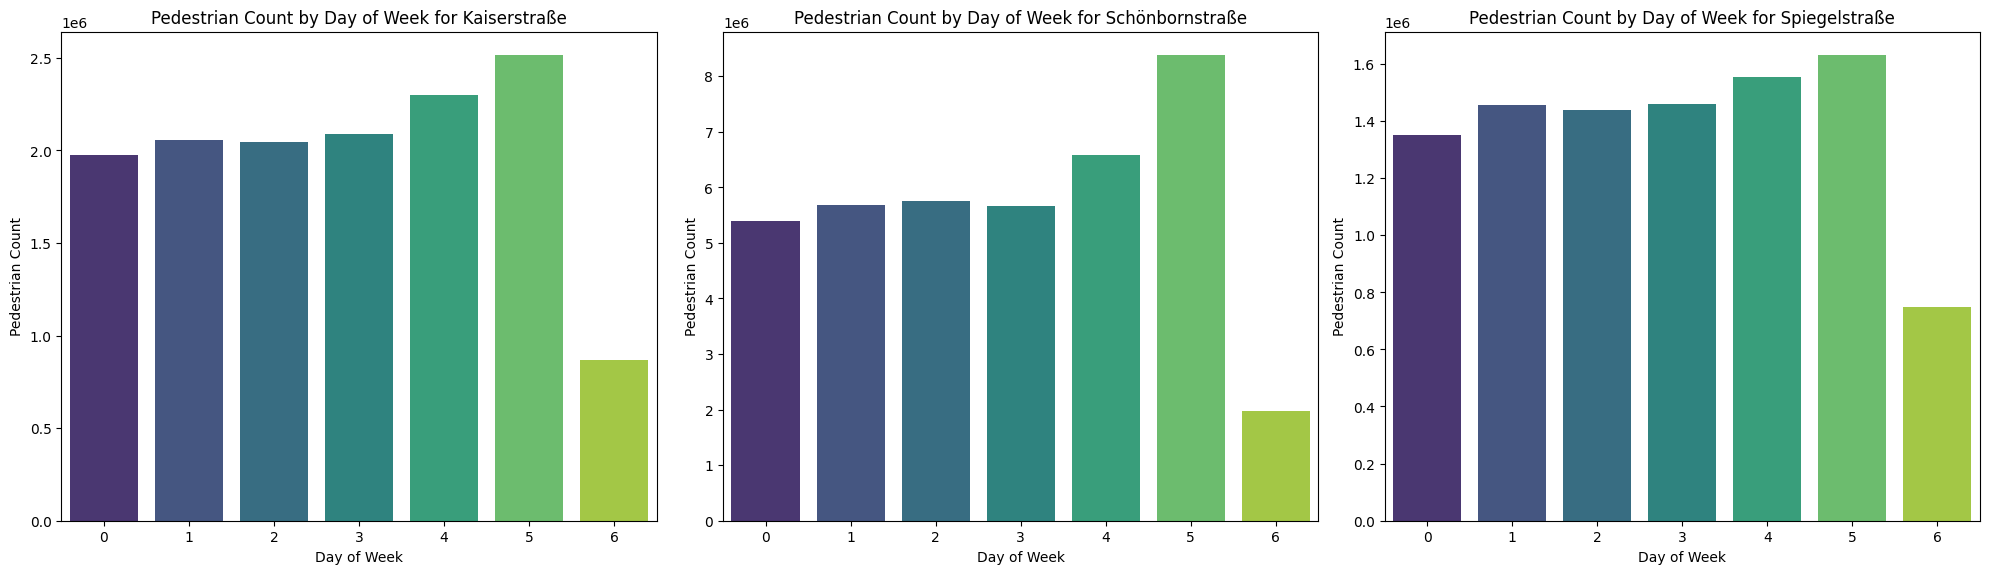

In [30]:
# Analysis of the weekday and pedestrian count over the different locations

# Group pedestrians by location and weekday
df_day_weekd_loc = df_day.groupby(['location_name', 'day_of_week'])['pedestrians_count'].sum().reset_index()

# Sort the weekdays by the weekday_order
df_day_weekd_loc['day_of_week'] = df_day_weekd_loc['day_of_week'].map(weekday_order)

# Make 3 subplots for each location
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot the data for each location
for i, location in enumerate(df_day_weekd_loc['location_name'].unique()):
    data = df_day_weekd_loc[df_day_weekd_loc['location_name'] == location]
    sns.barplot(x='day_of_week', y='pedestrians_count', data=data, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Pedestrian Count by Day of Week for {location}')
    axes[i].set_xlabel('Day of Week')
    axes[i].set_ylabel('Pedestrian Count')

plt.tight_layout()

# show plot
plt.show()


- As we can see, all 3 Locations have a similar distribution of pedestrians on the weekdays.

- Even though Sundays see the fewest pedestrians on Spiegelstraße, there are still significantly more people walking there compared to Schönbornstraße, likely due to Spiegelstraße's proximity to the Jura University.

In [31]:
# Show the pedestrian count for each day of the week and location
# Create a new dataframe with weekdays as columns and locations as rows
df_day_weekd_loc_pivot = df_day_weekd_loc.pivot(index='location_name', columns='day_of_week', values='pedestrians_count')
# Normalize the data by dividing by the mean of each row
df_day_weekd_loc_pivot = df_day_weekd_loc_pivot.div(df_day_weekd_loc_pivot.mean(axis=1), axis=0)

# Now substract 1 to make the mean value 0 and then multiply by 100 to get percentages
df_day_weekd_loc_pivot = ((df_day_weekd_loc_pivot - 1) * 100).round(0).astype(int)

# Add percentage to the values and convert to string
df_day_weekd_loc_pivot = df_day_weekd_loc_pivot.astype(str) + '%'

# Rename the columns to the actual weekday names
df_day_weekd_loc_pivot.columns = df_day_weekd_loc_pivot.columns.map({v: k for k, v in weekday_order.items()})

# Save the DataFrame to a CSV file 
df_day_weekd_loc_pivot.to_csv('Grafiken/Day/day_weekd.csv')

df_day_weekd_loc_pivot


day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
location_name,,,,,,,
Kaiserstraße,0%,4%,3%,6%,16%,27%,-56%
Schönbornstraße,-4%,1%,2%,0%,17%,49%,-65%
Spiegelstraße,-2%,6%,5%,6%,13%,18%,-46%


The table above shows how many pedestrians are found on each weekday. + 10% Would mean that 10% more pedestrians are found on this weekday compared to the average.

- For example on the Schönbornstraße, 49% more pedestrians are found on Saturday compared to the average.

- There is a sharp drop in pedestrian traffic on Sundays across all three locations compared to their respective averages, with Kaiserstraße seeing 56% fewer pedestrians, Schönbornstraße 65% fewer, and Spiegelstraße 45% fewer.

- This strong contrast in pedestrian activity on Sundays suggests that all these areas experience a significant decline in foot traffic on that day. 

- However, Saturday sees the highest pedestrian count above the average, particularly in Schönbornstraße (49% more pedestrians), indicating that weekends overall have a strong impact on pedestrian activity, with Saturday being a high-traffic day and Sunday a low-traffic day.

- Additionally, Kaiserstraße and Spiegelstraße show fairly balanced activity throughout the weekdays, whereas Schönbornstraße has minimal variation during the week, except for the big spike on Saturdays. This suggests that Schönbornstraße may be more influenced by weekend events, shopping, or leisure activities compared to the other streets



### Average number of pedestrian per month


/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/2375257962.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_day_month.index, y=df_day_month.values, palette='viridis')


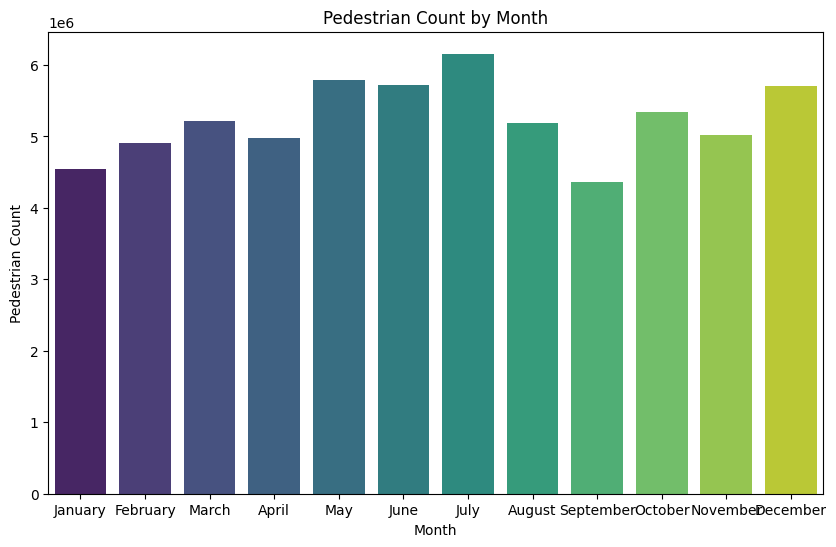

In [32]:
month_order = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Plot the average number of pedestrians per month

# Group pedestrians by month
df_day_month = df_day.groupby('month')['pedestrians_count'].sum()

# Sort the months by the month_order
df_day_month = df_day_month.sort_index(key=lambda x: x.map(month_order))

# Plot the data
plt.figure(figsize=(10, 6))


sns.barplot(x=df_day_month.index, y=df_day_month.values, palette='viridis')

plt.xlabel('Month')
plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count by Month')

# save plot
plt.savefig('Grafiken/Day/pedestrian_count_by_month.png')

plt.show()

### Average number of pedestrians per weekday and month

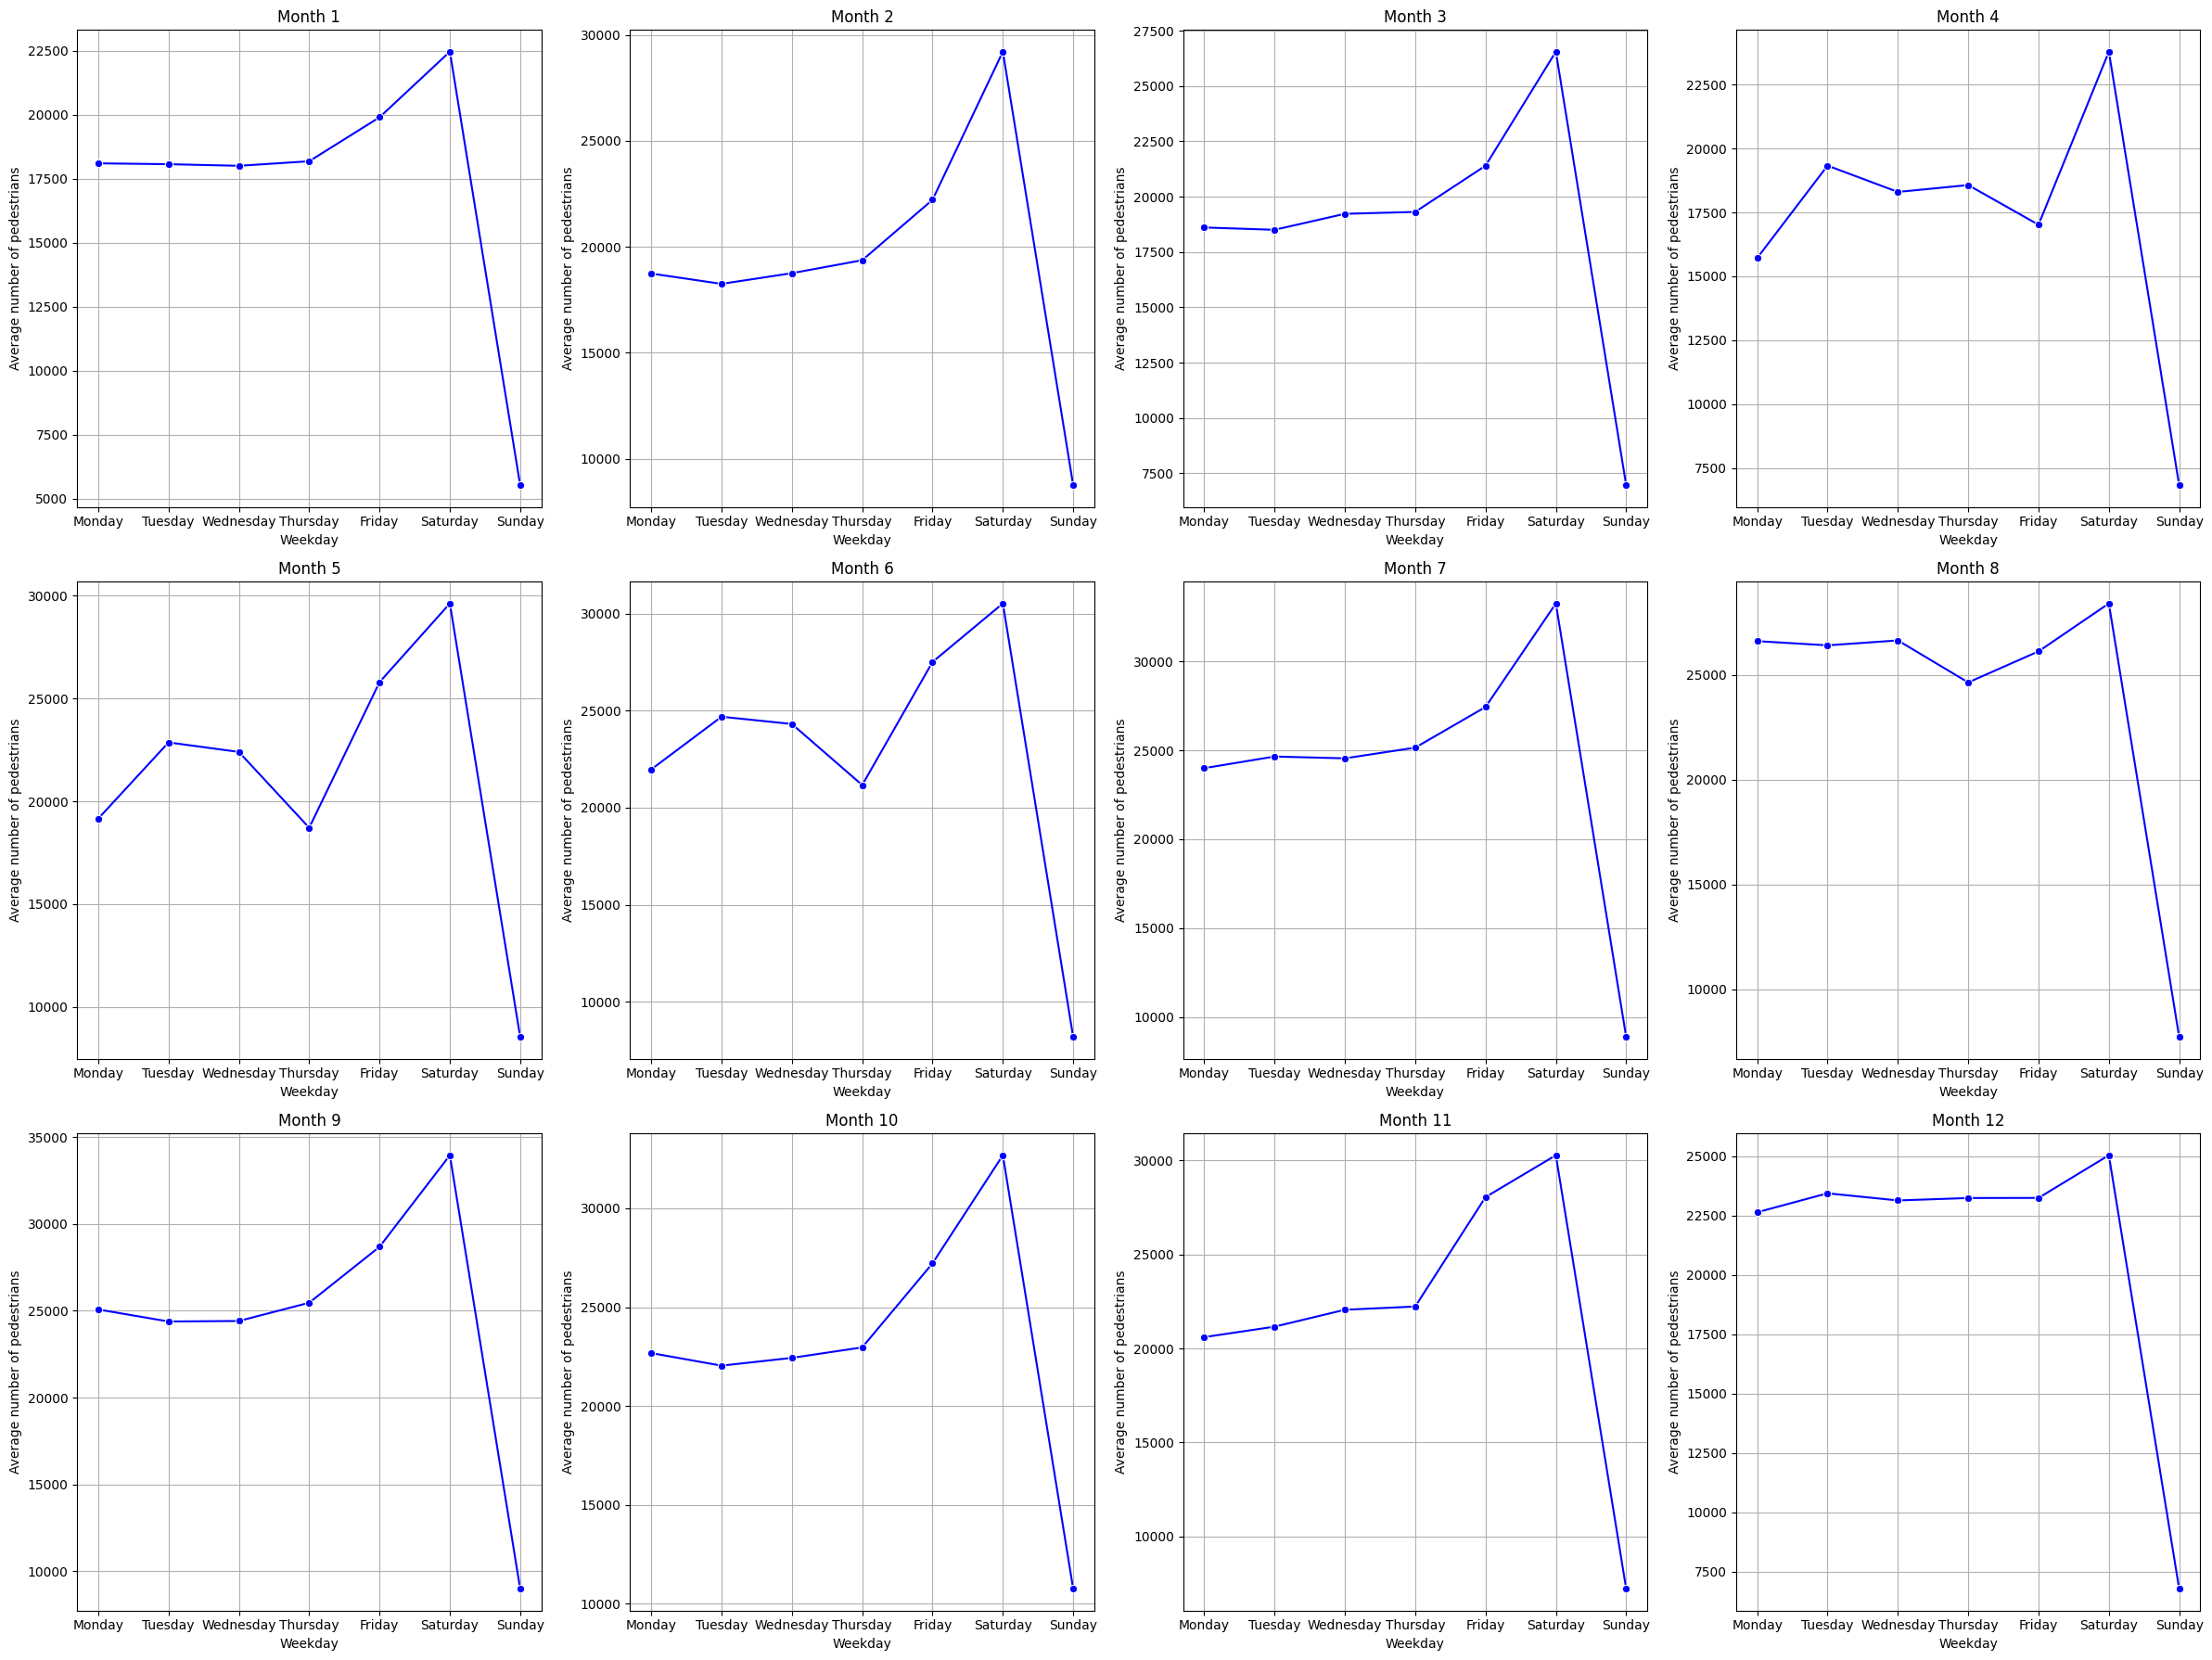

In [33]:
# If 'date' is already the index, reset it
if df_day.index.name == 'date':
    df_day = df_day.reset_index()

# Convert the 'date' column to datetime format
df_day['date'] = pd.to_datetime(df_day['date'])

# Set the index to 'date' again
df_day.set_index('date', inplace=True)

# Check for duplicate indices and remove them if necessary
df_day = df_day.loc[~df_day.index.duplicated(keep='first')]

# Resample to daily frequency, if necessary
df_day = df_day.resample('D').ffill()  # Adjust to daily frequency if necessary

# Create a column for the weekday (numeric)
df_day['day_of_week_num'] = df_day.index.dayofweek

# Weekday names for the X-axis
weekdays_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Number of months
num_months = 12

# Create a figure with subplots for each month
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 18))
axes = axes.flatten()  # Flatten the axes array for easier access

# Iterate through each month and create the plot
for month in range(1, num_months + 1):
    # Filter the data for the current month
    df_month = df_day[df_day.index.month == month]
    
    # Calculate the average number of pedestrians per weekday
    average_weekly_pedestrians = df_month.groupby('day_of_week_num')['pedestrians_count'].mean()
    
    # Plot the average number of pedestrians per weekday
    sns.lineplot(x=average_weekly_pedestrians.index, y=average_weekly_pedestrians.values, marker='o', color='b', ax=axes[month - 1])
    axes[month - 1].set_title(f'Month {month}')
    axes[month - 1].set_xlabel('Weekday')
    axes[month - 1].set_ylabel('Average number of pedestrians')
    axes[month - 1].set_xticks(range(7))  # Ensure all weekdays are displayed
    axes[month - 1].set_xticklabels(weekdays_names)  # Weekday names as X-axis labels
    axes[month - 1].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig('Grafiken/Day/average_pedestrians_week_months.png')
plt.show()  # Show the plot to free up memory



- During the different months the pedestrian count is quite similar on the weekdays. 

### Average number of pedestrians per weekday and season

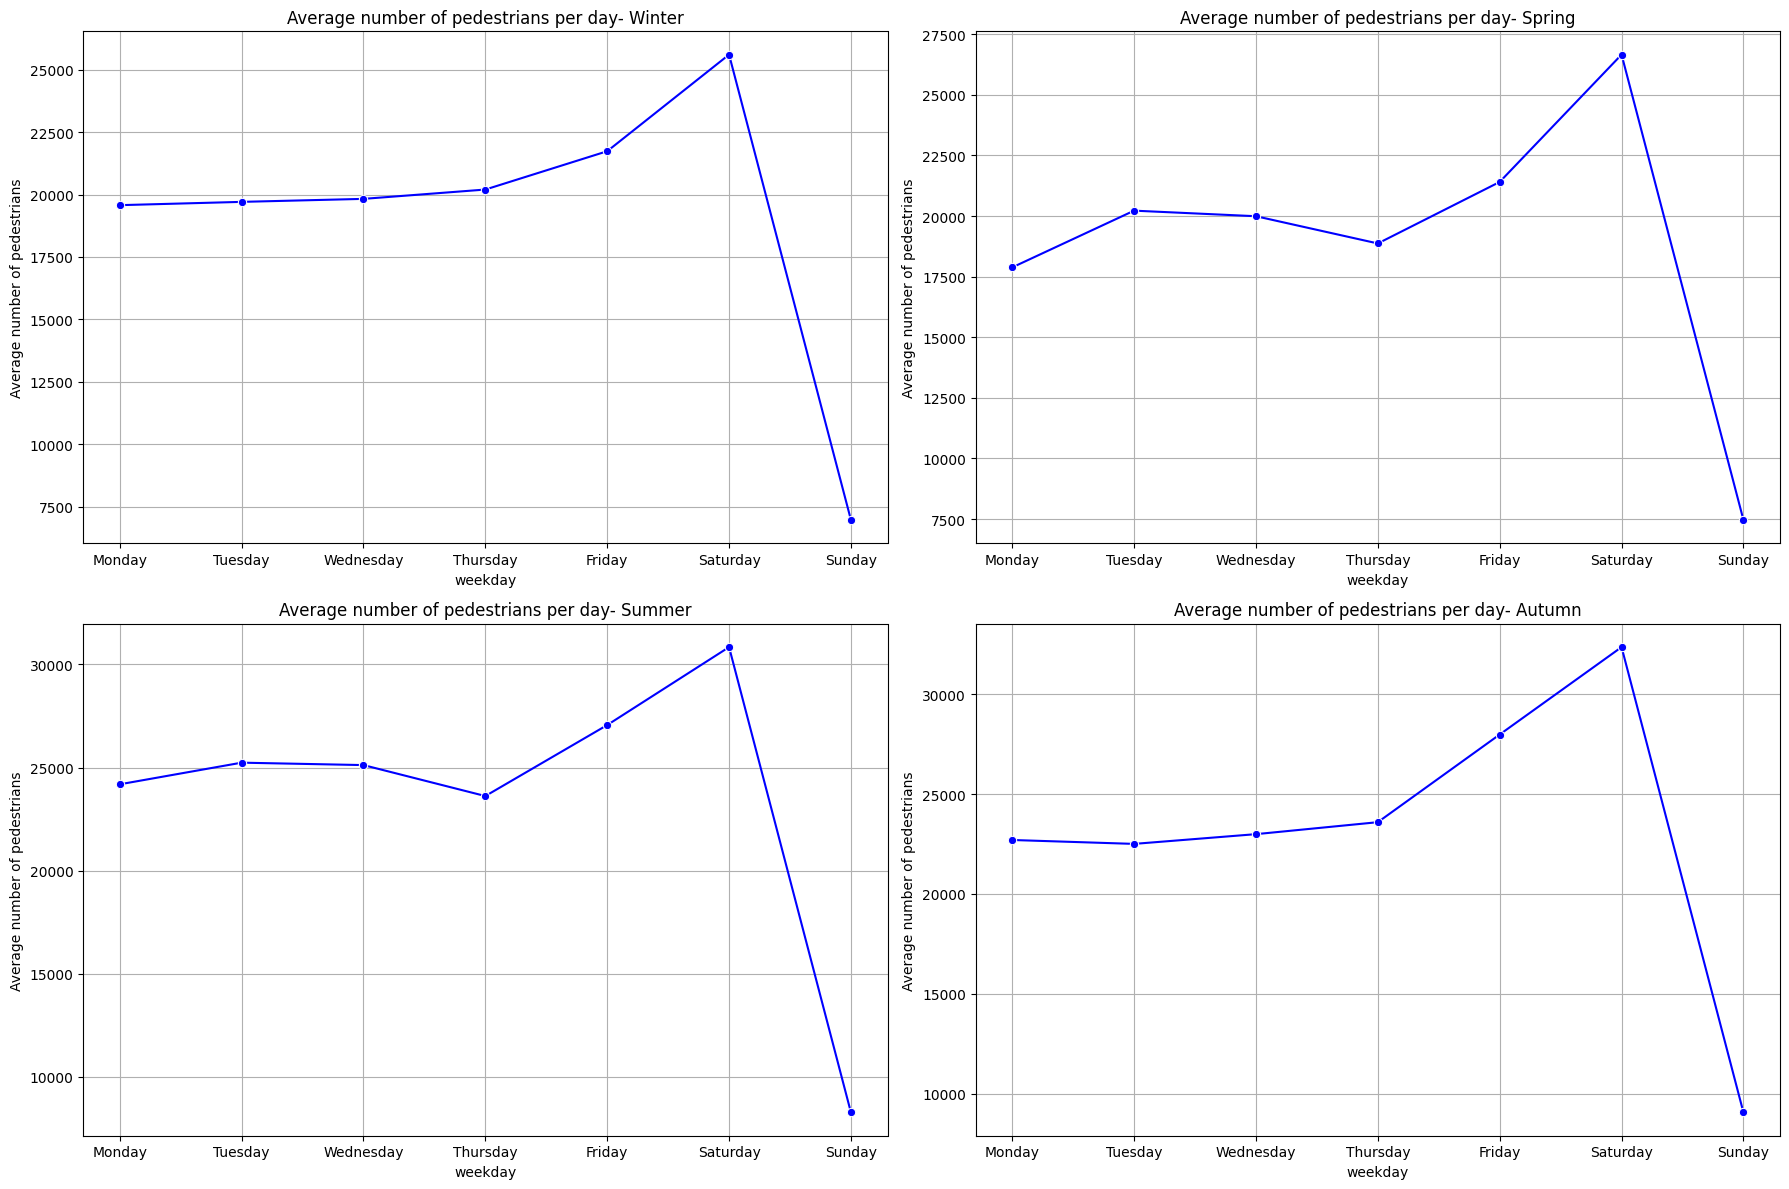

In [34]:
# Sicherstellen, dass 'date' eine Datetime-Spalte ist und als Index gesetzt wird
if df_day.index.name == 'date':
    df_day = df_day.reset_index()

df_day.set_index('date', inplace=True)

# Überprüfen auf doppelte Indizes und diese entfernen, falls vorhanden
df_day = df_day.loc[~df_day.index.duplicated(keep='first')]

# Resample auf tägliche Frequenz, falls notwendig
df_day = df_day.resample('D').ffill()

# Erstellen einer Spalte für den Wochentag (numerisch)
df_day['day_of_week_num'] = df_day.index.dayofweek

# Funktion zur Bestimmung der Jahreszeit basierend auf dem Monat
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Erstellen einer Spalte für die Jahreszeit
df_day['season'] = df_day.index.month.map(get_season)

# Iterieren durch jede Jahreszeit und Erstellen der Plots
seasons = df_day['season'].unique()

# Erstellen einer Figur mit 2 Spalten für die Plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()  # Flatten der Axes-Array für einfacheren Zugriff

# Iteration durch die Jahreszeiten und Erstellen der Plots
for i, season in enumerate(seasons):
    # Filtern der Daten für die aktuelle Jahreszeit
    df_season = df_day[df_day['season'] == season]
    
    # Berechnen der durchschnittlichen Anzahl der Passanten pro Wochentag
    average_weekly_pedestrians = df_season.groupby('day_of_week_num')['pedestrians_count'].mean()
    
    # Wochentag-Namen für die X-Achse
    weekdays_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Plotten der durchschnittlichen Anzahl der Passanten pro Wochentag
    sns.lineplot(x=average_weekly_pedestrians.index, y=average_weekly_pedestrians.values, marker='o', color='b', ax=axes[i])
    axes[i].set_title(f'Average number of pedestrians per day- {season}')
    axes[i].set_xlabel('weekday')
    axes[i].set_ylabel('Average number of pedestrians')
    axes[i].set_xticks(range(7))  # Sicherstellen, dass alle Wochentage angezeigt werden
    axes[i].set_xticklabels(weekdays_names)  # Wochentag-Namen als X-Achsen-Beschriftungen
    axes[i].grid(True)

# Layout anpassen, um Überlappungen zu vermeiden
plt.tight_layout()

# Speichern des Plots
plt.savefig('Grafiken/Day/average_pedestrians_week_seasons.png')
plt.show()  # Schließen des Plots, um Speicher freizugeben


- During the different season the pedestrian count is quite similar on the weekdays.

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/927638984.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pedestrians_per_season.index, y=pedestrians_per_season.values, palette='viridis')


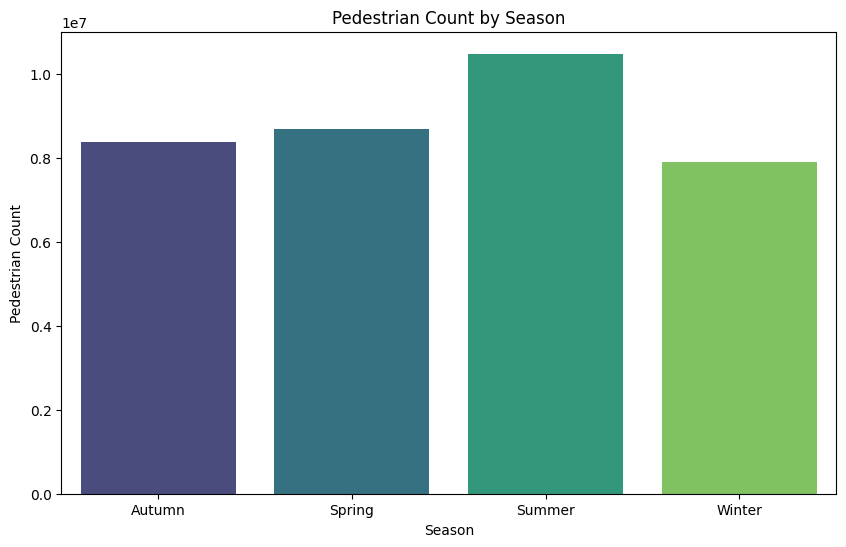

In [35]:
season_order = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}

# Count the number of pedestrians for each season
pedestrians_per_season = df_day.groupby('season')['pedestrians_count'].sum()


# Plot the number of pedestrians per season
plt.figure(figsize=(10, 6))

sns.barplot(x=pedestrians_per_season.index, y=pedestrians_per_season.values, palette='viridis')

plt.xlabel('Season')
plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count by Season')

# Save the plot
plt.savefig('Grafiken/Day/pedestrian_count_by_season.png')

plt.show()

### Lecture time vs non lecture time


In [36]:
df_day.month

date
2020-01-08    January
2020-01-09    January
2020-01-10    January
2020-01-11    January
2020-01-12    January
               ...   
2024-08-13     August
2024-08-14     August
2024-08-15     August
2024-08-16     August
2024-08-17     August
Freq: D, Name: month, Length: 1684, dtype: object

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/4977119.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pedestrians_per_lecture_time.index, y=pedestrians_per_lecture_time.values, palette='viridis')


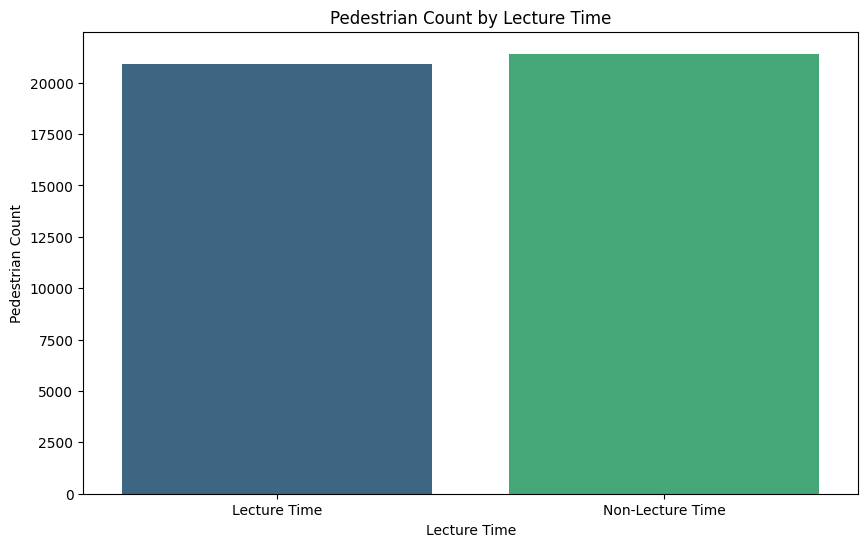

In [37]:
lecture_times_order = {'Lecture Time': 0, 'Non-Lecture Time': 1}

# Lecture times (October to January (inclusive) and April to July (inclusive))
months_lecture_time = ['October', 'November', 'December', 'January', 'April', 'May', 'June', 'July']

df_day['lecture_time'] = df_day.month.isin(months_lecture_time).map({True: 'Lecture Time', False: 'Non-Lecture Time'})

# Count the number of pedestrians for lecture and non-lecture times
pedestrians_per_lecture_time = df_day.groupby('lecture_time')['pedestrians_count'].mean()

# Plot the number of pedestrians for lecture and non-lecture times
plt.figure(figsize=(10, 6))

sns.barplot(x=pedestrians_per_lecture_time.index, y=pedestrians_per_lecture_time.values, palette='viridis')

plt.xlabel('Lecture Time')
plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count by Lecture Time')

# Save the plot
plt.savefig('Grafiken/Day/pedestrian_count_by_lecture_time.png')

plt.show()




- Eventhough the lecture time is not a significant factor, we can see that there are slightly more pedestrians during the lecture time compared to the non lecture time.


### Average number of pedestrians per workday vs. weekend

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/2951056348.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekdays['date_only'] = weekdays.index.date
/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/2951056348.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekends['date_only'] = weekends.index.date


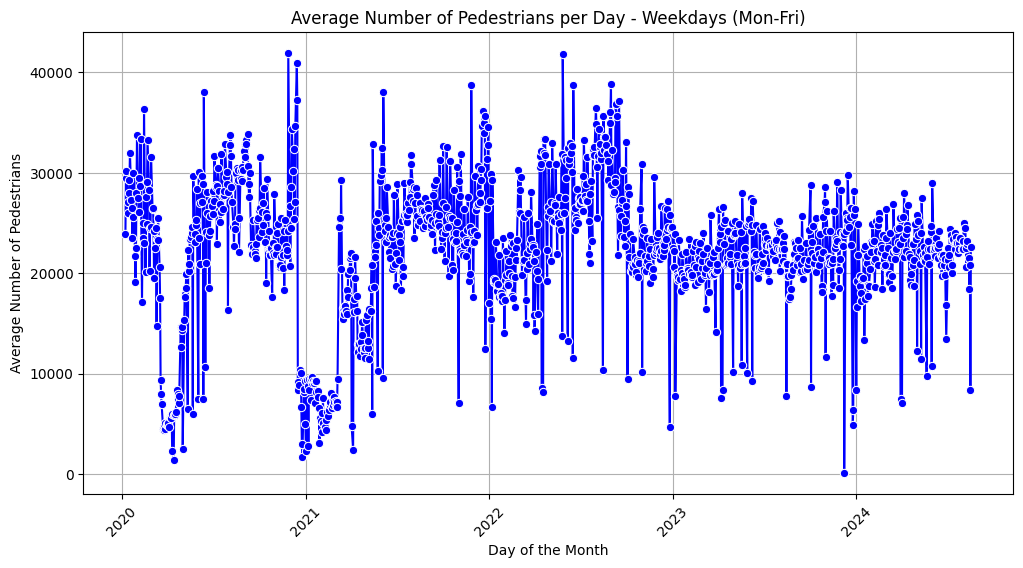

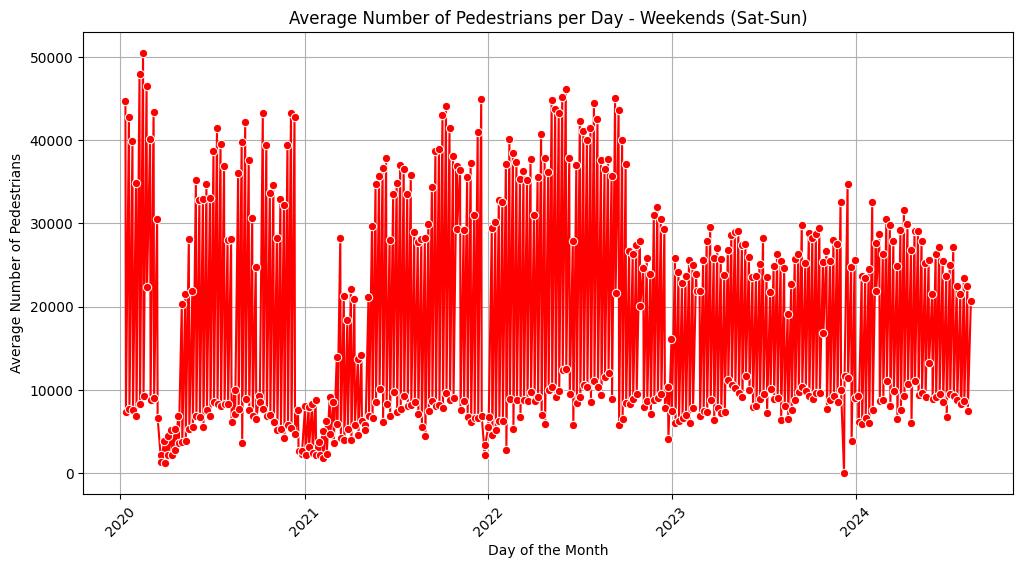

In [38]:

# Wenn 'date' bereits der Index ist, Index zurücksetzen
if df_day.index.name == 'date':
    df_day = df_day.reset_index()

# Setze den Index erneut auf 'date'
df_day.set_index('date', inplace=True)

# Überprüfen auf doppelte Indizes und diese entfernen, falls vorhanden
df_day = df_day.loc[~df_day.index.duplicated(keep='first')]

# Resample to fill missing dates (falls stündliche Daten wichtig sind)
df_day = df_day.resample('D').ffill()  # Hier auf tägliche Frequenz umstellen, falls notwendig

# Daten nach Werktagen und Wochenenden trennen
weekdays = df_day[df_day['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekends = df_day[df_day['day_of_week'].isin(['Saturday', 'Sunday'])]

# Um sicherzustellen, dass die Gruppierung nach Datum konsistent ist
# Erstellen einer neuen Spalte 'date_only' mit dem Datum ohne Zeit
weekdays['date_only'] = weekdays.index.date
weekends['date_only'] = weekends.index.date

# Durchschnittliche Anzahl der Passanten pro Tag berechnen
daily_weekday_pedestrians = weekdays.groupby('date_only')['pedestrians_count'].mean()
daily_weekend_pedestrians = weekends.groupby('date_only')['pedestrians_count'].mean()


# Plot für Werktage
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_weekday_pedestrians.index, y=daily_weekday_pedestrians.values, marker='o', color='b')
plt.title('Average Number of Pedestrians per Day - Weekdays (Mon-Fri)')
plt.xlabel('Day of the Month')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(rotation=45)  # Drehen der X-Achse, um Datum besser lesbar zu machen
plt.grid(True)

# Speichern des Plots für Werktage
plt.savefig('Grafiken/Day/average_pedestrians_weekdays.png')
plt.show()  # Schließen des Plots, um Speicher freizugeben

# Plot für Wochenenden
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_weekend_pedestrians.index, y=daily_weekend_pedestrians.values, marker='o', color='r')
plt.title('Average Number of Pedestrians per Day - Weekends (Sat-Sun)')
plt.xlabel('Day of the Month')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(rotation=45)  # Drehen der X-Achse, um Datum besser lesbar zu machen
plt.grid(True)

# Speichern des Plots für Wochenenden
plt.savefig('Grafiken/Day/average_pedestrians_weekends.png')
plt.show()  # Schließen des Plots, um Speicher freizugeben


/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/3740873759.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekdays['date_only'] = weekdays.index.date
/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/3740873759.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saturdays['date_only'] = saturdays.index.date
/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/3740873759.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

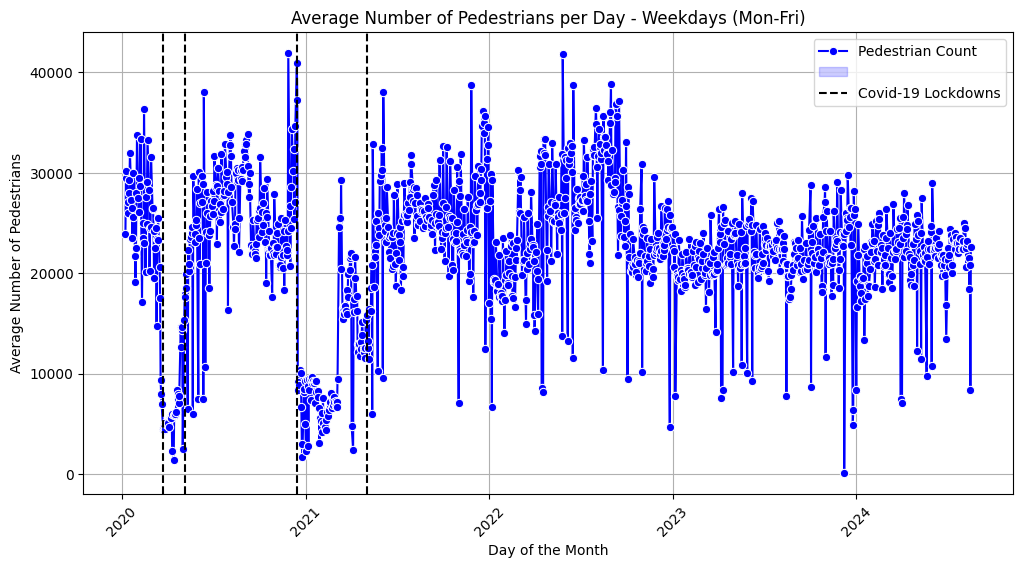

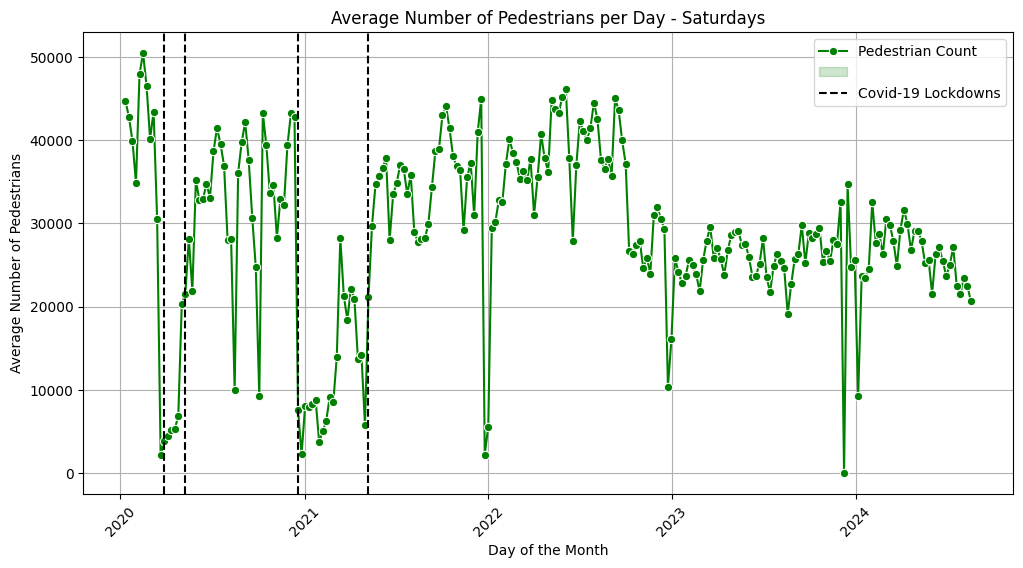

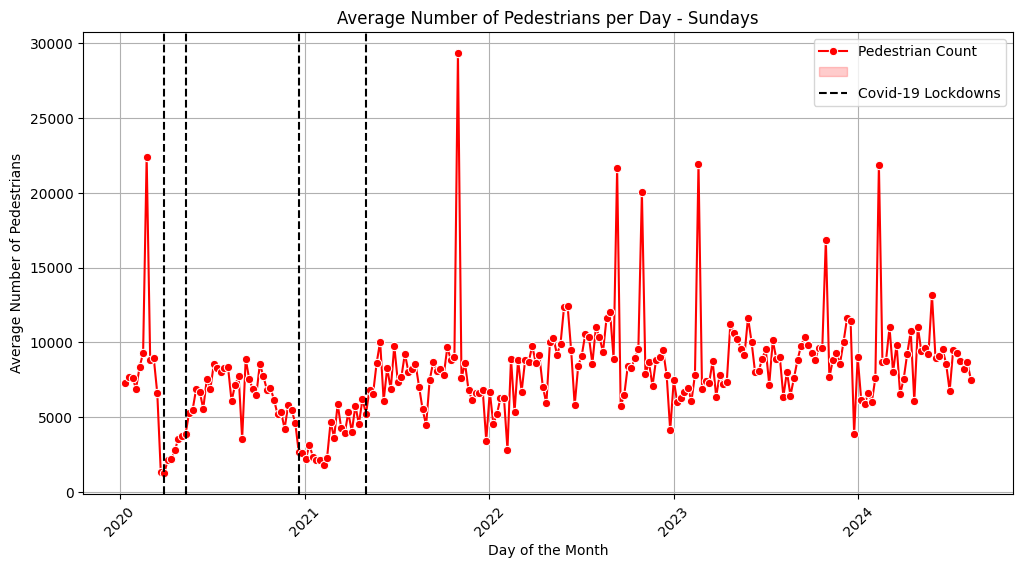

In [39]:
# Wenn 'date' bereits der Index ist, Index zurücksetzen
if df_day.index.name == 'date':
    df_day = df_day.reset_index()

# Setze den Index erneut auf 'date'
df_day.set_index('date', inplace=True)

# Überprüfen auf doppelte Indizes und diese entfernen, falls vorhanden
df_day = df_day.loc[~df_day.index.duplicated(keep='first')]

# Resample to fill missing dates (falls stündliche Daten wichtig sind)
df_day = df_day.resample('D').ffill()  # Hier auf tägliche Frequenz umstellen, falls notwendig

# Daten nach Werktagen, Samstagen und Sonntagen trennen
weekdays = df_day[df_day['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
saturdays = df_day[df_day['day_of_week'] == 'Saturday']
sundays = df_day[df_day['day_of_week'] == 'Sunday']

# Um sicherzustellen, dass die Gruppierung nach Datum konsistent ist
# Erstellen einer neuen Spalte 'date_only' mit dem Datum ohne Zeit
weekdays['date_only'] = weekdays.index.date
saturdays['date_only'] = saturdays.index.date
sundays['date_only'] = sundays.index.date

# Durchschnittliche Anzahl der Passanten pro Tag berechnen
daily_weekday_pedestrians = weekdays.groupby('date_only')['pedestrians_count'].mean()
daily_saturday_pedestrians = saturdays.groupby('date_only')['pedestrians_count'].mean()
daily_sunday_pedestrians = sundays.groupby('date_only')['pedestrians_count'].mean()

daily_weekday_pedestrians.index = pd.to_datetime(daily_weekday_pedestrians.index)
daily_saturday_pedestrians.index = pd.to_datetime(daily_saturday_pedestrians.index)
daily_sunday_pedestrians.index = pd.to_datetime(daily_sunday_pedestrians.index)

def get_day_after(df, date):
    dates_after = df[df.index > date].index
    return dates_after[0]



weekday_after_lockdown = get_day_after(daily_weekday_pedestrians, '2020-03-22')
saturday_after_lockdown = get_day_after(daily_saturday_pedestrians, '2020-03-22')
sunday_after_lockdown = get_day_after(daily_sunday_pedestrians, '2020-03-22')

weekday_after_lockdown_end = get_day_after(daily_weekday_pedestrians, '2020-05-04')
saturday_after_lockdown_end = get_day_after(daily_saturday_pedestrians, '2020-05-04')
sunday_after_lockdown_end = get_day_after(daily_sunday_pedestrians, '2020-05-04')

weekday_after_lockdown2 = get_day_after(daily_weekday_pedestrians, '2020-12-13')
saturday_after_lockdown2 = get_day_after(daily_saturday_pedestrians, '2020-12-13')
sunday_after_lockdown2 = get_day_after(daily_sunday_pedestrians, '2020-12-13')

weekday_after_lockdown2_end = get_day_after(daily_weekday_pedestrians, '2021-05-01')
saturday_after_lockdown2_end = get_day_after(daily_saturday_pedestrians, '2021-05-01')
sunday_after_lockdown2_end = get_day_after(daily_sunday_pedestrians, '2021-05-01')

# Plot für Werktage
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_weekday_pedestrians.index, y=daily_weekday_pedestrians.values, marker='o', color='b')
plt.title('Average Number of Pedestrians per Day - Weekdays (Mon-Fri)')
plt.xlabel('Day of the Month')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(rotation=45)
plt.grid(True)

plt.axvline(weekday_after_lockdown, color='k', linestyle='--')
plt.axvline(weekday_after_lockdown_end, color='k', linestyle='--')
plt.axvline(weekday_after_lockdown2, color='k', linestyle='--')
plt.axvline(weekday_after_lockdown2_end, color='k', linestyle='--')

plt.legend(['Pedestrian Count', '',  'Covid-19 Lockdowns'])
plt.savefig('Grafiken/Day/average_pedestrians_weekdays.png')
plt.show()

# Plot für Samstage
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_saturday_pedestrians.index, y=daily_saturday_pedestrians.values, marker='o', color='g')
plt.title('Average Number of Pedestrians per Day - Saturdays')
plt.xlabel('Day of the Month')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(rotation=45)
plt.grid(True)

plt.axvline(saturday_after_lockdown, color='k', linestyle='--')
plt.axvline(saturday_after_lockdown_end, color='k', linestyle='--')
plt.axvline(saturday_after_lockdown2, color='k', linestyle='--')
plt.axvline(saturday_after_lockdown2_end, color='k', linestyle='--')

plt.legend(['Pedestrian Count', '', 'Covid-19 Lockdowns'])
plt.savefig('Grafiken/Day/average_pedestrians_saturdays.png')
plt.show()

# Plot für Sonntage
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_sunday_pedestrians.index, y=daily_sunday_pedestrians.values, marker='o', color='r')
plt.title('Average Number of Pedestrians per Day - Sundays')
plt.xlabel('Day of the Month')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(rotation=45)
plt.grid(True)

plt.axvline(sunday_after_lockdown, color='k', linestyle='--')
plt.axvline(sunday_after_lockdown_end, color='k', linestyle='--')
plt.axvline(sunday_after_lockdown2, color='k', linestyle='--')
plt.axvline(sunday_after_lockdown2_end, color='k', linestyle='--')

plt.legend(['Pedestrian Count','','Covid-19 Lockdowns'])
plt.savefig('Grafiken/Day/average_pedestrians_sundays.png')
plt.show()


In [40]:
# Show for saturdays and sundays the days where the pedestrian count was higher than the 99th percentile

# Calculate the 99th percentile for the pedestrian count for Saturdays and Sundays
percentile_95_saturday = daily_saturday_pedestrians.quantile(0.95)
percentile_95_sunday = daily_sunday_pedestrians.quantile(0.95)

# Filter the days where the pedestrian count was higher than the 99th percentile
high_pedestrians_saturday = daily_saturday_pedestrians[daily_saturday_pedestrians > percentile_95_saturday]
high_pedestrians_sunday = daily_sunday_pedestrians[daily_sunday_pedestrians > percentile_95_sunday]

# Sort the days by the pedestrian count
high_pedestrians_saturday = high_pedestrians_saturday.sort_values(ascending=False)
high_pedestrians_sunday = high_pedestrians_sunday.sort_values(ascending=False)

In [41]:
high_pedestrians_saturday

date_only
2020-02-15    50480.0
2020-02-08    47913.0
2020-02-22    46509.0
2022-06-04    46207.0
2022-05-28    45180.0
2022-09-10    45026.0
2021-12-18    44955.0
2022-05-07    44772.0
2020-01-11    44711.0
2022-07-30    44528.0
2021-10-09    44110.0
2022-05-14    43780.0
Name: pedestrians_count, dtype: float64

In [42]:
high_pedestrians_sunday

date_only
2021-10-31    29348.0
2020-02-23    22408.0
2023-02-19    21931.0
2024-02-11    21878.0
2022-09-11    21671.0
2022-10-30    20066.0
2023-10-29    16873.0
2024-05-26    13162.0
2022-06-05    12444.0
2022-05-29    12374.0
2022-08-28    12030.0
2023-05-28    11655.0
Name: pedestrians_count, dtype: float64

### Average number of pedestrians per day within an average week

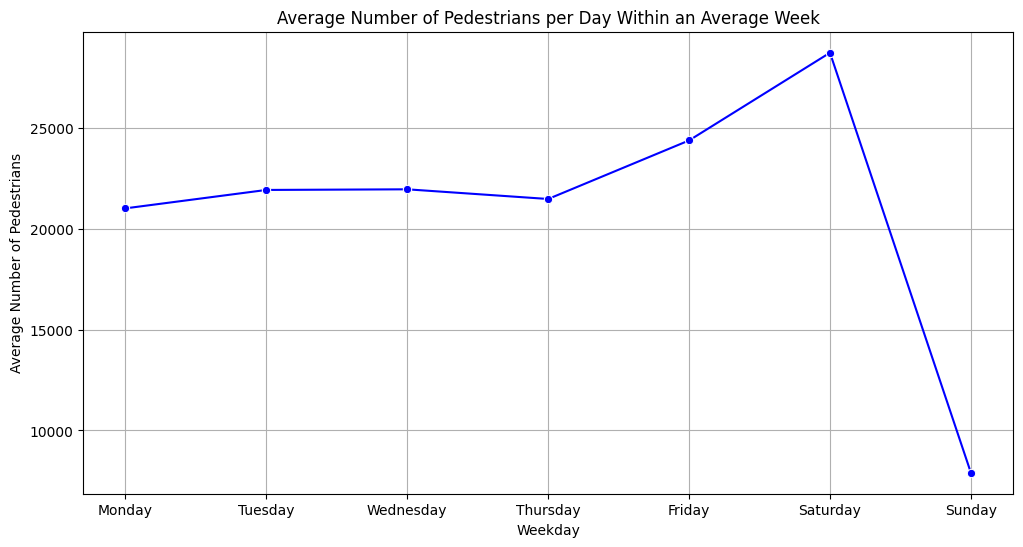

In [43]:
# Wenn 'date' bereits der Index ist, Index zurücksetzen
if df_day.index.name == 'date':
    df_day = df_day.reset_index()

# Setze den Index erneut auf 'date'
df_day.set_index('date', inplace=True)

# Überprüfen auf doppelte Indizes und diese entfernen, falls vorhanden
df_day = df_day.loc[~df_day.index.duplicated(keep='first')]

# Resample auf tägliche Frequenz, falls notwendig
df_day = df_day.resample('D').ffill()  # Hier auf tägliche Frequenz umstellen, falls notwendig


# Erstellen einer Spalte für den Wochentag (numerisch)
df_day['day_of_week_num'] = df_day.index.dayofweek

# Berechnen der durchschnittlichen Anzahl der Passanten pro Wochentag
average_weekly_pedestrians = df_day.groupby('day_of_week_num')['pedestrians_count'].mean()

# Wochentag-Namen für die X-Achse
weekdays_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotten der durchschnittlichen Anzahl der Passanten pro Wochentag
plt.figure(figsize=(12, 6))
sns.lineplot(x=average_weekly_pedestrians.index, y=average_weekly_pedestrians.values, marker='o', color='b')
plt.title('Average Number of Pedestrians per Day Within an Average Week')
plt.xlabel('Weekday')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(ticks=range(7), labels=weekdays_names)  # Wochentag-Namen als X-Achsen-Beschriftungen
plt.grid(True)


# Speichern des Plots
plt.savefig('Grafiken/Day/average_pedestrians_week.png')
plt.show()  # Schließen des Plots, um Speicher freizugeben


- As we can see, most of the pedestrians in Würzburg are found on Saturday and Friday.
- The least pedestrians are found on Sunday, where shops are mostly closed.

### Average Number of Pedestrians by Weather Condition

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/3241990445.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_pedestrians_by_weather.index, y=average_pedestrians_by_weather.values, palette='viridis')


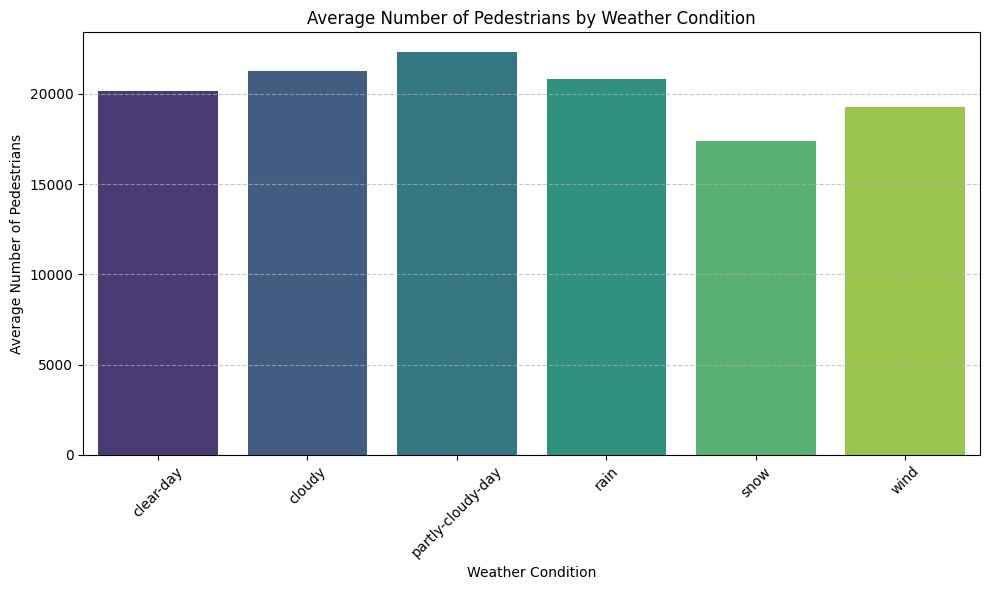

In [44]:
# Sicherstellen, dass 'date' als DatetimeIndex gesetzt ist
df_day.index = pd.to_datetime(df_day.index)

# Gruppiere die Daten nach 'weather_condition' und berechne den Durchschnitt der Fußgängeranzahl
average_pedestrians_by_weather = df_day.groupby('weather_condition')['pedestrians_count'].mean()

# Plotten der Ergebnisse
plt.figure(figsize=(10, 6))
sns.barplot(x=average_pedestrians_by_weather.index, y=average_pedestrians_by_weather.values, palette='viridis')
plt.title('Average Number of Pedestrians by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(rotation=45)  # Dreht die X-Achsen-Beschriftungen für bessere Lesbarkeit
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Diagramm anzeigen
plt.tight_layout()
plt.savefig('Grafiken/Day/average_pedestrians_by_weather_condition.png')
plt.show()


- There is no big difference of the average number of pedestrians with the different weather conditions.
- However, the least pedestrians are found on snowy & windy days.

## Covid Effect on Pedestrian Count

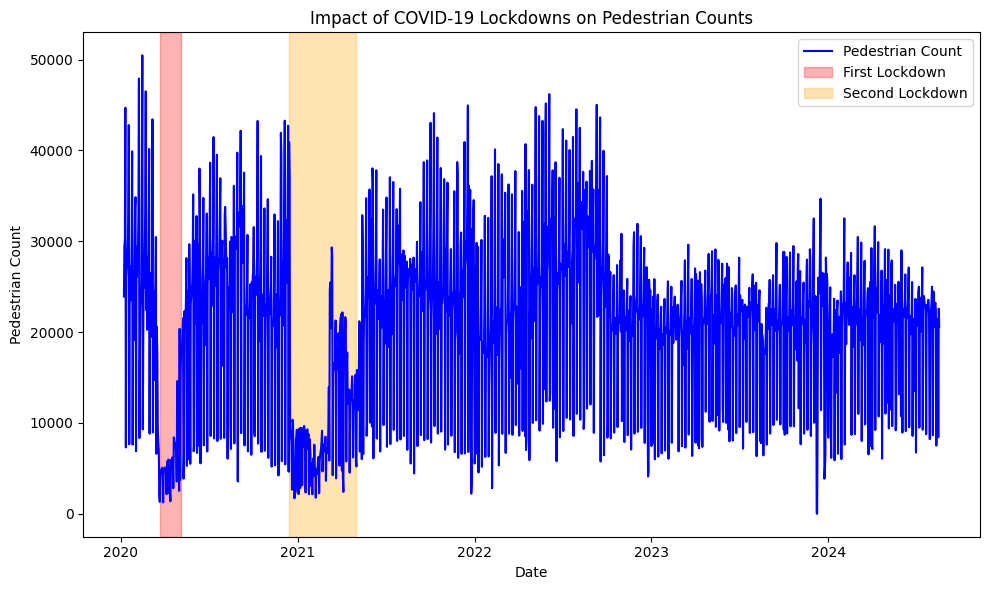

In [45]:

# Ensure 'date' is the index, and it's a datetime type
df_day.index = pd.to_datetime(df_day.index)

# Define the lockdown periods
lockdown1_start = pd.to_datetime('2020-03-22')
lockdown1_end = pd.to_datetime('2020-05-04')

lockdown2_start = pd.to_datetime('2020-12-13')
lockdown2_end = pd.to_datetime('2021-05-01')

# Plot pedestrian counts
plt.figure(figsize=(10, 6))
plt.plot(df_day.index, df_day['pedestrians_count'], label='Pedestrian Count', color='blue')

# Mark the first lockdown period
plt.axvspan(lockdown1_start, lockdown1_end, color='red', alpha=0.3, label='First Lockdown')

# Mark the second lockdown period
plt.axvspan(lockdown2_start, lockdown2_end, color='orange', alpha=0.3, label='Second Lockdown')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Pedestrian Count')
plt.title('Impact of COVID-19 Lockdowns on Pedestrian Counts')
plt.legend()

# tight layout
plt.tight_layout()
# Save the plot
plt.savefig('Grafiken/Day/pedestrian_counts_covid_lockdowns.png')

# Show the plot
plt.show()

- As we can see, there was a big drop in pedestrian traffic during the COVID-19 Lockdowns.
- Therefore we remove this data from the dataset.


# Special Events in Würzburg
- Kiliani Volksfest 
- Frühjahrsvolksfest
- Africa Festival
- Street Food Festival
- Stadtfest
- Umsonst & Draußen
- Mozartfest
- Weinfest
- Hafensommer
- Würzburger Weihnachtsmarkt
- Würzburger Weindorf
- Weinparade
- Würzburger Residenzlauf

### Events with Dates from 2020-2024

**Carnival**
- 2020-02-23: Faschingssonntag
- 2024-02-03: Würzburger Kindermaskenzug
- 2024-02-11: Würzburger Faschingsumzug - Faschingssonntag
- 2022-02-13: Faschingssonntag
- 2023-02-19: Faschingssonntag

**Verkaufsoffener Sonntag (Mandelsonntag)**
- 2022-10-30
- 2023-10-29
- 2021-10-31

**Christmas Market**
- 2023-12-01 to 2023-12-23
- 2022-11-05 to 2022-12-23
- 2020-11-27 to 2020-12-15

**Stadtfest**
- 2022-09-16 to 2022-09-17
- 2023-09-13 to 2023-09-14

**Residenzlauf**
- 2022-05-01
- 2023-04-30
- 2024-04-28

**Mozartfest**
- 2020-06-09 to 2020-06-27
- 2021-05-28 to 2021-06-27
- 2022-05-20 to 2022-06-19
- 2023-06-02 to 2023-07-02
- 2024-05-24 to 2024-06-23

**Residenz Weinfest**
- 2024-06-28 to 2024-07-07
- 2023-06-30 to 2023-07-09
- 2022-07-10

**Kiliani**
- 2022-07-01 to 2022-07-17
- 2023-06-30 to 2023-07-16
- 2024-07-05 to 2024-07-21

**Frühjahrsvolksfest**
- 2024-03-09 to 2024-03-24
- 2023-03-18 to 2023-04-02
- 2022-03-26 to 2022-04-10

**Africa Festival**
- 2024-05-30 to 2024-06-02
- 2023-05-26 to 2023-05-29
- 2022-05-26 to 2022-05-29

**Street Food Festival**
- 2022-05-28 to 2022-05-29

**Allerheiligenmesse**
- 2023-10-28 to 2023-11-12
- 2022-10-29 to 2022-11-13

**Mandelsonntag**
- 2021-10-31
- 2020-10-31
- 2022-10-27
- 2023-10-29

**Hafensommer**
- 2024-07-19 to 2024-08-04
- 2023-07-21 to 2023-08-06
- 2022-07-22 to 2022-08-07
- 2021-08-07 to 2021-08-08

**Umsonst & Draußen**
- 2024-06-20 to 2024-06-23
- 2023-06-08 to 2023-06-11
- 2022-06-16 to 2022-06-19
- 2021-09-02 to 2021-09-05

**Weindorf**
- 2022-05-25 to 2022-06-06
- 2023-05-26 to 2023-06-04
- 2024-05-29 to 2024-06-09

**Weinparade**
- 2024-08-22 to 2024-09-01
- 2023-08-24 to 2023-09-03
- 2022-08-25 to 2022-09-01


In [46]:
special_events = [
    # Fasching
    '2020-02-23', '2024-02-03', '2024-02-11', '2022-02-13', '2023-02-19',
    
    # Verkaufsoffener Sonntag (Mandelsonntag)
    '2022-10-30', '2023-10-29', '2021-10-31',
    
    # Christmas Market
    '2023-12-01', '2023-12-23', '2022-11-05', '2022-12-23', '2020-11-27', '2020-12-15',
    
    # Stadtfest
    '2022-09-16', '2022-09-17', '2023-09-13', '2023-09-14',
    
    # Residenzlauf
    '2022-05-01', '2023-04-30', '2024-04-28',
    
    # Mozartfest
    '2020-06-09', '2020-06-27', '2021-05-28', '2021-06-27', '2022-05-20', '2022-06-19', '2023-06-02', '2023-07-02', '2024-05-24', '2024-06-23',
    
    # Residenz Weinfest
    '2024-06-28', '2024-07-07', '2023-06-30', '2023-07-09', '2022-07-10',
    
    # Kiliani
    '2022-07-01', '2022-07-17', '2023-06-30', '2023-07-16', '2024-07-05', '2024-07-21',
    
    # Frühjahrsvolksfest
    '2024-03-09', '2024-03-24', '2023-03-18', '2023-04-02', '2022-03-26', '2022-04-10',
    
    # Africa Festival
    '2024-05-30', '2024-06-02', '2023-05-26', '2023-05-29', '2022-05-26', '2022-05-29',
    
    # Street Food Festival
    '2022-05-28', '2022-05-29',
    
    # Allerheiligenmesse
    '2023-10-28', '2023-11-12', '2022-10-29', '2022-11-13',
    
    # Mandelsonntag
    '2021-10-31', '2020-10-31', '2022-10-27', '2023-10-29',
    
    # Hafensommer
    '2024-07-19', '2024-08-04', '2023-07-21', '2023-08-06', '2022-07-22', '2022-08-07', '2021-08-07', '2021-08-08',
    
    # Umsonst & Draußen
    '2024-06-20', '2024-06-23', '2023-06-08', '2023-06-11', '2022-06-16', '2022-06-19', '2021-09-02', '2021-09-05',
    
    # Weindorf
    '2022-05-25', '2022-06-06', '2023-05-26', '2023-06-04', '2024-05-29', '2024-06-09',
    
    # Weinparade
    '2024-08-22', '2024-09-01', '2023-08-24', '2023-09-03', '2022-08-25', '2022-09-01'
]


In [47]:
df_day.columns

Index(['weather_condition', 'temperature', 'min_temperature',
       'pedestrians_count', 'location_id', 'location_name', 'GeoPunkt',
       'day_of_week', 'month', 'longitude', 'latitude', 'is_weekend',
       'is_holiday', 'season', 'pedestrians_count_7d_lag', 'day_of_week_num',
       'lecture_time'],
      dtype='object')

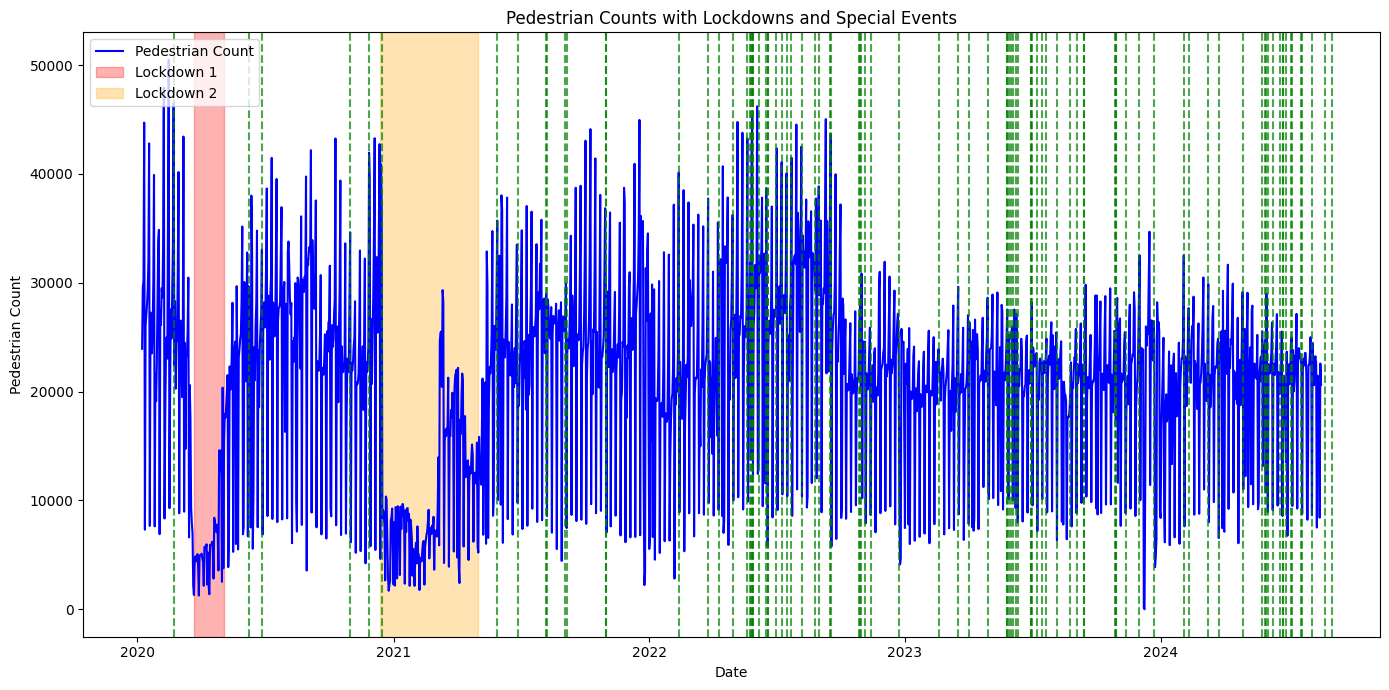

In [48]:
# Convert special events to datetime
special_event_dates = pd.to_datetime(special_events)

# Plot the pedestrian count
plt.figure(figsize=(14, 7))
plt.plot(df_day.index, df_day['pedestrians_count'], label='Pedestrian Count', color='blue')

# Highlight lockdown periods
plt.axvspan(lockdown1_start, lockdown1_end, color='red', alpha=0.3, label='Lockdown 1')
plt.axvspan(lockdown2_start, lockdown2_end, color='orange', alpha=0.3, label='Lockdown 2')

# Plot special events as vertical lines
for event_date in special_event_dates:
    plt.axvline(event_date, color='green', linestyle='--', alpha=0.7)

# Add labels and title
plt.title('Pedestrian Counts with Lockdowns and Special Events')
plt.xlabel('Date')
plt.ylabel('Pedestrian Count')

# Add a legend
plt.legend()

# tight layout
plt.tight_layout()

# Save the plot
plt.savefig('Grafiken/Day/pedestrian_counts_lockdown_special_events.png')

# Show the plot
plt.show()

In [49]:
# Read the data
df_filtered_day = pd.read_csv('Data/Data Files/filtered_lockdown_day_data.csv')


In [50]:
df_filtered_day.head()

,date,weather_condition,temperature,min_temperature,pedestrians_count,location_id,location_name,GeoPunkt,day_of_week,month,longitude,latitude,is_weekend,is_holiday,season
0,2024-01-11,clear-day,0.0,-11.0,12585,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Thursday,January,9.934698,49.794834,0,0,Winter
1,2024-01-12,partly-cloudy-day,-2.0,-9.0,13515,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Friday,January,9.934698,49.794834,0,0,Winter
2,2024-01-13,cloudy,0.0,-3.0,13352,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Saturday,January,9.934698,49.794834,1,0,Winter
3,2024-01-14,partly-cloudy-day,0.0,-5.0,5335,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Sunday,January,9.934698,49.794834,1,0,Winter
4,2024-01-15,snow,1.0,-4.0,11718,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",Monday,January,9.934698,49.794834,0,0,Winter


In [51]:
df_filtered_day.columns

Index(['date', 'weather_condition', 'temperature', 'min_temperature',
       'pedestrians_count', 'location_id', 'location_name', 'GeoPunkt',
       'day_of_week', 'month', 'longitude', 'latitude', 'is_weekend',
       'is_holiday', 'season'],
      dtype='object')

In [52]:
# set date to datetime
df_filtered_day['date'] = pd.to_datetime(df_filtered_day['date'])

# Setze den Index erneut auf 'date'
df_filtered_day.set_index('date', inplace=True)




In [53]:
# Convert special events to datetime
special_event_dates = pd.to_datetime(special_events)

# add a column for special events
df_filtered_day['is_special_event'] = df_filtered_day.index.isin(special_event_dates)




In [54]:
# get the average pedestrian count per day

# Calculate the average pedestrian count per day
average_pedestrians_per_day = df_filtered_day['pedestrians_count'].mean()

average_pedestrians_per_day

21228.988624612204

In [55]:
pedestrians_by_special_event = df_filtered_day.groupby(['day_of_week', 'is_special_event']).agg({'pedestrians_count': 'mean'})

pedestrians_by_special_event

pedestrians_count
day_of_week is_special_event                   
Friday      False                  24637.465789
            True                   24387.027027
Monday      False                  20697.295567
            True                   10975.000000
Saturday    False                  29521.588689
            True                   30423.250000
Sunday      False                   7996.522659
            True                   10831.365854
Thursday    False                  21826.766497
            True                   18257.043478
Tuesday     False                  21619.801453
            True                   27053.000000
Wednesday   False                  21837.480296
            True                   23037.285714

In [61]:
# check which location has the most entries

# Count the number of entries for each location
location_counts = df_filtered_day['location_name'].value_counts()

# Display the number of entries for each location
location_counts

location_name
Schönbornstraße    1505
Spiegelstraße       709
Kaiserstraße        687
Name: count, dtype: int64

In [66]:
# filter the data for schönbornstraße
df_schonborn = df_filtered_day[df_filtered_day['location_name'] == 'Schönbornstraße']

df_event_days_most = df_schonborn[df_schonborn['is_special_event'] == True]['day_of_week'].value_counts()

df_event_days_most

day_of_week
Sunday       36
Friday       16
Saturday     13
Thursday     11
Wednesday     3
Monday        2
Tuesday       1
Name: count, dtype: int64

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/4035538409.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_event_days.index, y=df_event_days.values, palette='viridis')


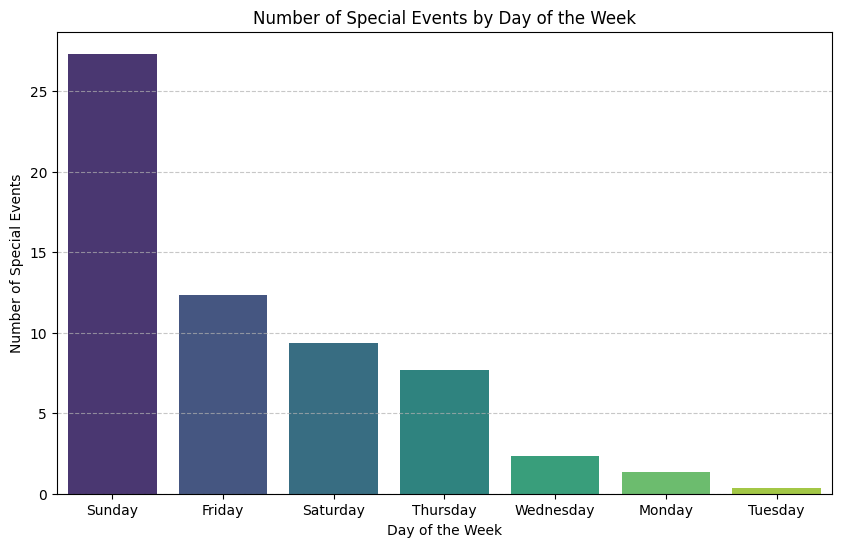

In [56]:
df_event_days = df_filtered_day.loc[df_filtered_day['is_special_event'] == True]['day_of_week'].value_counts()/3

# create a bar plot for the pedestrian count by special event
plt.figure(figsize=(10, 6))
sns.barplot(x=df_event_days.index, y=df_event_days.values, palette='viridis')
plt.title('Number of Special Events by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Special Events')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# save plot
plt.savefig('Grafiken/Day/special_events_by_day_of_week.png')

plt.show()

In [59]:
df_event_days

day_of_week
Sunday       27.333333
Friday       12.333333
Saturday      9.333333
Thursday      7.666667
Wednesday     2.333333
Monday        1.333333
Tuesday       0.333333
Name: count, dtype: float64

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_4932/1089565610.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pedestrians_by_special_event.index, y=pedestrians_by_special_event.values, palette='viridis')


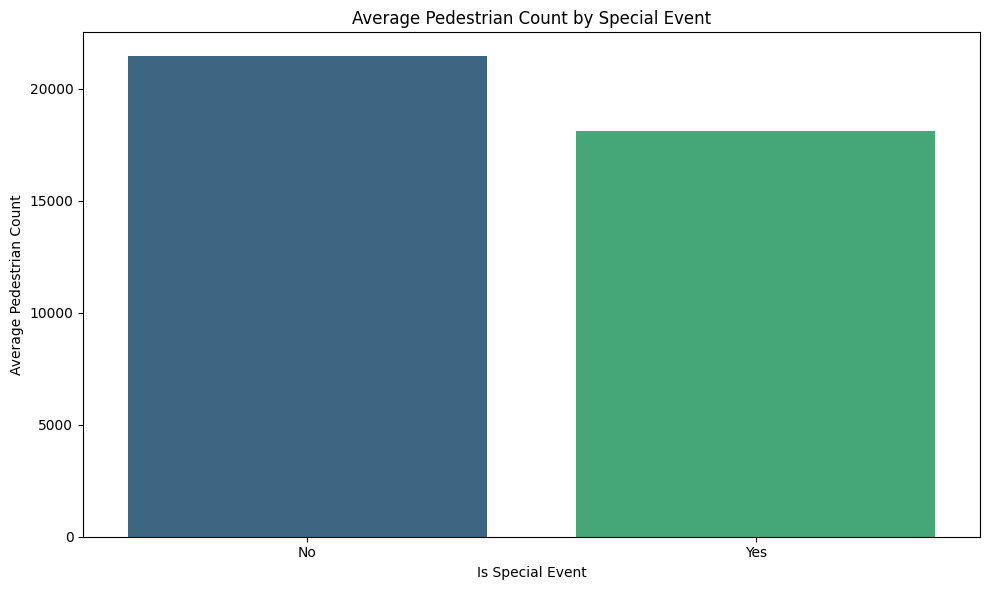

In [57]:
# Group by 'is_special_event' and calculate the mean number of pedestrians per day
pedestrians_by_special_event = df_filtered_day.groupby('is_special_event')['pedestrians_count'].mean()

# Create the barplot to compare averages
plt.figure(figsize=(10, 6))
sns.barplot(x=pedestrians_by_special_event.index, y=pedestrians_by_special_event.values, palette='viridis')

# Set plot labels and titles for clarity
plt.xlabel('Is Special Event')
plt.ylabel('Average Pedestrian Count')
plt.title('Average Pedestrian Count by Special Event')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# Save and display the plot
plt.tight_layout()
plt.savefig('Grafiken/Day/average_pedestrian_count_by_event.png')
plt.show()


- The peaks in pedestrian counts are found on special events in Würzburg. 
- On these days most pedestrians are found in Würzburg.